# 2. Train CNN

# 2.0 -- Import Relevant Libraries

In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D,MaxPooling2D

/home/dustin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/dustin/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os

In [4]:
#pickle_path = 'Pickled/Small_Train/'

pickle_path = 'Pickled/Train_Data/'

#pickle_path = 'Pickled/Test_Data/'

# 2.1 -- Define Data Generator.

### The amplitude of each training example varies over many orders of magnitude. Due to this, the function that will perform the act of getting 'chunks' from storage into memory (Data_Gen) will also perform for the log-normalization of the data. The bit of code immediately below this text is responsible for obtaining the log-mean of ALL the chunks of training data. This value will then be fed into Data_Gen for training. 

In [5]:
X_files = sorted(os.listdir(pickle_path + "Spectra"))
num_files = len(X_files)
count=0

mean_list=[]

for X_file in X_files:
    
    file = open(pickle_path + "Spectra/" + X_file, "rb")
    X=pickle.load(file)
    file.close()
    
    mean_list.append(np.mean(np.log(X)))
    
    count+=1
    percent_complete = round(count/num_files*100,1)
    print(str(percent_complete) + '% Complete', end='\r', flush=True)
    
mean_log_amplitude = np.mean(mean_list)

### Check the output...

In [6]:
print("Mean: " + str(round(mean_log_amplitude,3)))
print("2 Sigma: " + str(round(2*np.std(mean_list),3)))

Mean: -10.189
2 Sigma: 0.062


### Its nice to see that about 95% of the training data log-means fall within a 0.6% deviation of the mean

### Below is the function that generates the training data from storage:

In [12]:
# Returns i-th chunk of X,y data at path.
def Data_Gen(X_path, y_path, mean_log_amplitude):
        
    # X data
    file = open(pickle_path + "Spectra/" + X_path, "rb")
    X=pickle.load(file)
    file.close()
    
    X = np.stack((X,), -1)    
    X = np.log(X) - mean_log_amplitude # log + normalization
    
    # y data
    file = open(pickle_path + "Targets/" + y_path, "rb")
    y=pickle.load(file)
    file.close()
    
    y = keras.utils.np_utils.to_categorical(y)        
    
    return X,y

# 2.2 -- Define CNN Model

### The model architechture below was defined mostly through a trial and error approach. Some research was conducted in determining a simple general CNN architecture. It was found that the below model works well.

In [13]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(4, 4), strides=(1, 1), activation='relu', input_shape=(129,129,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(32, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 16)      272       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 64)        32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10816)             0         
__________

### Train CNN. For now use a validation split of 12.5% to track model performance.

In [16]:
X_files = sorted(os.listdir(pickle_path + "Spectra"))
y_files = sorted(os.listdir(pickle_path + "Targets"))

num_chunks = len(y_files)
iteration = 0

acc=[]
loss=[]

val_loss=[]
val_acc=[]

num_epochs = 10

for _ in range(num_epochs):
    
    for X_file, y_file in zip(X_files,y_files):

        iteration +=1
        print('chunk number: ' + str(iteration) + " of " + str(num_chunks*num_epochs))

        X,y = Data_Gen(X_file, y_file, mean_log_amplitude)

        history=model.fit(X, y, batch_size=128, epochs=1, validation_split=1/8, verbose = 2)

        val_acc.append(history.history['val_acc'])
        acc.append(history.history['acc'])
        
        loss.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        

    

chunk number: 1 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 5s - loss: 4.5310 - acc: 0.1808 - val_loss: 1.7636 - val_acc: 0.2578
chunk number: 2 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.7583 - acc: 0.2254 - val_loss: 1.6909 - val_acc: 0.2578
chunk number: 3 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.5665 - acc: 0.3739 - val_loss: 1.4153 - val_acc: 0.4375
chunk number: 4 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.2766 - acc: 0.5045 - val_loss: 1.1031 - val_acc: 0.5625
chunk number: 5 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.2507 - acc: 0.5167 - val_loss: 1.2319 - val_acc: 0.5547
chunk number: 6 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.1029 - acc: 0.5703 - val_loss: 1.0192 - val_acc: 0.6016
chunk number: 7 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - 

chunk number: 55 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.8097 - acc: 0.6886 - val_loss: 0.7432 - val_acc: 0.7188
chunk number: 56 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.8284 - acc: 0.6741 - val_loss: 0.7375 - val_acc: 0.7031
chunk number: 57 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7949 - acc: 0.7009 - val_loss: 0.7241 - val_acc: 0.7109
chunk number: 58 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.8123 - acc: 0.6920 - val_loss: 0.7573 - val_acc: 0.7500
chunk number: 59 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7770 - acc: 0.7098 - val_loss: 0.7324 - val_acc: 0.7266
chunk number: 60 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.8909 - acc: 0.6797 - val_loss: 0.7880 - val_acc: 0.6797
chunk number: 61 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 

chunk number: 109 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6883 - acc: 0.7489 - val_loss: 0.6427 - val_acc: 0.7656
chunk number: 110 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6930 - acc: 0.7500 - val_loss: 0.6757 - val_acc: 0.7422
chunk number: 111 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7049 - acc: 0.7132 - val_loss: 0.7039 - val_acc: 0.7422
chunk number: 112 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7280 - acc: 0.7232 - val_loss: 0.6051 - val_acc: 0.7812
chunk number: 113 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7116 - acc: 0.7254 - val_loss: 0.6547 - val_acc: 0.7578
chunk number: 114 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7934 - acc: 0.7009 - val_loss: 0.7300 - val_acc: 0.7188
chunk number: 115 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 163 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6978 - acc: 0.7333 - val_loss: 0.8793 - val_acc: 0.6484
chunk number: 164 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6205 - acc: 0.7667 - val_loss: 0.7339 - val_acc: 0.7344
chunk number: 165 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7281 - acc: 0.7210 - val_loss: 0.6267 - val_acc: 0.7500
chunk number: 166 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6949 - acc: 0.7411 - val_loss: 0.7350 - val_acc: 0.7188
chunk number: 167 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6626 - acc: 0.7478 - val_loss: 0.6144 - val_acc: 0.7188
chunk number: 168 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7060 - acc: 0.7165 - val_loss: 0.8382 - val_acc: 0.7188
chunk number: 169 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 217 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6582 - acc: 0.7556 - val_loss: 0.6205 - val_acc: 0.7656
chunk number: 218 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5847 - acc: 0.7757 - val_loss: 0.6049 - val_acc: 0.7734
chunk number: 219 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6338 - acc: 0.7522 - val_loss: 0.7142 - val_acc: 0.7188
chunk number: 220 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6636 - acc: 0.7467 - val_loss: 0.5974 - val_acc: 0.7734
chunk number: 221 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5745 - acc: 0.7634 - val_loss: 0.5199 - val_acc: 0.8125
chunk number: 222 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6225 - acc: 0.7455 - val_loss: 0.6400 - val_acc: 0.7656
chunk number: 223 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 271 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5620 - acc: 0.7734 - val_loss: 0.6273 - val_acc: 0.7500
chunk number: 272 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5967 - acc: 0.7779 - val_loss: 0.5837 - val_acc: 0.8047
chunk number: 273 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5318 - acc: 0.8036 - val_loss: 0.5935 - val_acc: 0.7656
chunk number: 274 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5547 - acc: 0.7935 - val_loss: 0.7029 - val_acc: 0.7422
chunk number: 275 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5788 - acc: 0.7935 - val_loss: 0.5334 - val_acc: 0.7734
chunk number: 276 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5499 - acc: 0.7991 - val_loss: 0.5683 - val_acc: 0.7891
chunk number: 277 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 325 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5117 - acc: 0.8147 - val_loss: 0.5729 - val_acc: 0.8125
chunk number: 326 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5375 - acc: 0.7902 - val_loss: 0.6709 - val_acc: 0.7422
chunk number: 327 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5504 - acc: 0.7891 - val_loss: 0.5029 - val_acc: 0.7969
chunk number: 328 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5805 - acc: 0.7790 - val_loss: 0.6285 - val_acc: 0.7656
chunk number: 329 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5949 - acc: 0.7879 - val_loss: 0.6236 - val_acc: 0.8125
chunk number: 330 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5464 - acc: 0.8002 - val_loss: 0.6696 - val_acc: 0.7422
chunk number: 331 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 379 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5102 - acc: 0.8092 - val_loss: 0.5347 - val_acc: 0.7734
chunk number: 380 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4984 - acc: 0.8114 - val_loss: 0.6165 - val_acc: 0.7891
chunk number: 381 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5083 - acc: 0.8025 - val_loss: 0.5041 - val_acc: 0.7891
chunk number: 382 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5507 - acc: 0.7902 - val_loss: 0.4502 - val_acc: 0.8281
chunk number: 383 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5609 - acc: 0.7913 - val_loss: 0.5512 - val_acc: 0.7812
chunk number: 384 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5393 - acc: 0.7946 - val_loss: 0.4982 - val_acc: 0.7734
chunk number: 385 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 433 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5010 - acc: 0.8036 - val_loss: 0.5198 - val_acc: 0.7812
chunk number: 434 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5152 - acc: 0.7879 - val_loss: 0.6295 - val_acc: 0.7500
chunk number: 435 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4817 - acc: 0.8125 - val_loss: 0.7236 - val_acc: 0.7266
chunk number: 436 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5000 - acc: 0.8114 - val_loss: 0.5166 - val_acc: 0.7812
chunk number: 437 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4843 - acc: 0.8203 - val_loss: 0.4486 - val_acc: 0.7891
chunk number: 438 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4998 - acc: 0.8192 - val_loss: 0.5646 - val_acc: 0.8125
chunk number: 439 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 487 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4872 - acc: 0.8158 - val_loss: 0.5739 - val_acc: 0.7891
chunk number: 488 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4988 - acc: 0.8025 - val_loss: 0.4467 - val_acc: 0.8203
chunk number: 489 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4405 - acc: 0.8449 - val_loss: 0.4337 - val_acc: 0.8750
chunk number: 490 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4467 - acc: 0.8259 - val_loss: 0.5488 - val_acc: 0.8281
chunk number: 491 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4642 - acc: 0.8304 - val_loss: 0.4991 - val_acc: 0.7969
chunk number: 492 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4445 - acc: 0.8259 - val_loss: 0.5333 - val_acc: 0.7656
chunk number: 493 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 541 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3903 - acc: 0.8571 - val_loss: 0.4327 - val_acc: 0.8594
chunk number: 542 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4505 - acc: 0.8371 - val_loss: 0.5873 - val_acc: 0.7734
chunk number: 543 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4562 - acc: 0.8225 - val_loss: 0.5453 - val_acc: 0.7656
chunk number: 544 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4499 - acc: 0.8404 - val_loss: 0.5388 - val_acc: 0.8125
chunk number: 545 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4633 - acc: 0.8304 - val_loss: 0.4663 - val_acc: 0.8203
chunk number: 546 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4466 - acc: 0.8426 - val_loss: 0.6119 - val_acc: 0.7891
chunk number: 547 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 595 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3957 - acc: 0.8605 - val_loss: 0.5127 - val_acc: 0.7969
chunk number: 596 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4707 - acc: 0.8348 - val_loss: 0.4615 - val_acc: 0.8203
chunk number: 597 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4215 - acc: 0.8393 - val_loss: 0.4800 - val_acc: 0.8438
chunk number: 598 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4166 - acc: 0.8203 - val_loss: 0.5794 - val_acc: 0.8281
chunk number: 599 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4186 - acc: 0.8337 - val_loss: 0.4316 - val_acc: 0.8359
chunk number: 600 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4391 - acc: 0.8147 - val_loss: 0.5298 - val_acc: 0.7969
chunk number: 601 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 649 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3628 - acc: 0.8393 - val_loss: 0.7918 - val_acc: 0.7812
chunk number: 650 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3872 - acc: 0.8438 - val_loss: 0.5980 - val_acc: 0.7969
chunk number: 651 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4275 - acc: 0.8281 - val_loss: 0.7228 - val_acc: 0.7344
chunk number: 652 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4256 - acc: 0.8337 - val_loss: 0.5100 - val_acc: 0.7734
chunk number: 653 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4348 - acc: 0.8348 - val_loss: 0.6238 - val_acc: 0.7578
chunk number: 654 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4308 - acc: 0.8326 - val_loss: 0.3922 - val_acc: 0.8203
chunk number: 655 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 703 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3418 - acc: 0.8605 - val_loss: 0.4677 - val_acc: 0.8203
chunk number: 704 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3358 - acc: 0.8717 - val_loss: 0.5015 - val_acc: 0.8125
chunk number: 705 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3315 - acc: 0.8750 - val_loss: 0.7204 - val_acc: 0.8125
chunk number: 706 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3111 - acc: 0.8862 - val_loss: 0.5503 - val_acc: 0.8359
chunk number: 707 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3461 - acc: 0.8783 - val_loss: 0.4847 - val_acc: 0.8281
chunk number: 708 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3565 - acc: 0.8661 - val_loss: 0.5190 - val_acc: 0.8203
chunk number: 709 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 757 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3649 - acc: 0.8571 - val_loss: 0.6573 - val_acc: 0.7578
chunk number: 758 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3238 - acc: 0.8817 - val_loss: 0.4799 - val_acc: 0.8281
chunk number: 759 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3501 - acc: 0.8750 - val_loss: 0.5166 - val_acc: 0.8359
chunk number: 760 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3982 - acc: 0.8549 - val_loss: 0.5686 - val_acc: 0.7812
chunk number: 761 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3676 - acc: 0.8683 - val_loss: 0.6285 - val_acc: 0.8359
chunk number: 762 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3621 - acc: 0.8795 - val_loss: 0.4760 - val_acc: 0.8359
chunk number: 763 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 811 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3261 - acc: 0.8772 - val_loss: 0.5366 - val_acc: 0.7812
chunk number: 812 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4033 - acc: 0.8571 - val_loss: 0.5551 - val_acc: 0.7812
chunk number: 813 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3215 - acc: 0.8638 - val_loss: 0.7157 - val_acc: 0.7812
chunk number: 814 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3697 - acc: 0.8438 - val_loss: 0.4477 - val_acc: 0.8594
chunk number: 815 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3210 - acc: 0.8828 - val_loss: 0.7426 - val_acc: 0.7500
chunk number: 816 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2720 - acc: 0.8984 - val_loss: 0.9664 - val_acc: 0.7734
chunk number: 817 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 865 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2980 - acc: 0.8906 - val_loss: 0.5241 - val_acc: 0.8047
chunk number: 866 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2718 - acc: 0.8951 - val_loss: 0.7365 - val_acc: 0.7266
chunk number: 867 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2455 - acc: 0.9074 - val_loss: 0.5061 - val_acc: 0.8203
chunk number: 868 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2819 - acc: 0.8817 - val_loss: 0.9616 - val_acc: 0.7422
chunk number: 869 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2813 - acc: 0.9085 - val_loss: 0.6632 - val_acc: 0.8125
chunk number: 870 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2198 - acc: 0.9096 - val_loss: 0.7688 - val_acc: 0.7500
chunk number: 871 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 919 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2526 - acc: 0.9074 - val_loss: 0.7551 - val_acc: 0.7812
chunk number: 920 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2510 - acc: 0.9062 - val_loss: 0.6097 - val_acc: 0.8125
chunk number: 921 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2424 - acc: 0.9174 - val_loss: 0.6293 - val_acc: 0.7969
chunk number: 922 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2745 - acc: 0.9051 - val_loss: 0.6874 - val_acc: 0.7734
chunk number: 923 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2471 - acc: 0.9074 - val_loss: 0.6448 - val_acc: 0.8281
chunk number: 924 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2634 - acc: 0.8817 - val_loss: 0.8262 - val_acc: 0.7500
chunk number: 925 of 1000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 973 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.1840 - acc: 0.9196 - val_loss: 1.2360 - val_acc: 0.7812
chunk number: 974 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.1788 - acc: 0.9342 - val_loss: 0.9288 - val_acc: 0.7578
chunk number: 975 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2066 - acc: 0.9275 - val_loss: 0.6803 - val_acc: 0.8125
chunk number: 976 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.1761 - acc: 0.9375 - val_loss: 0.8512 - val_acc: 0.7812
chunk number: 977 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2723 - acc: 0.8940 - val_loss: 0.6590 - val_acc: 0.7656
chunk number: 978 of 1000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2280 - acc: 0.9174 - val_loss: 1.1053 - val_acc: 0.7500
chunk number: 979 of 1000
Train on 896 samples, validate on 128 samples
Epoc

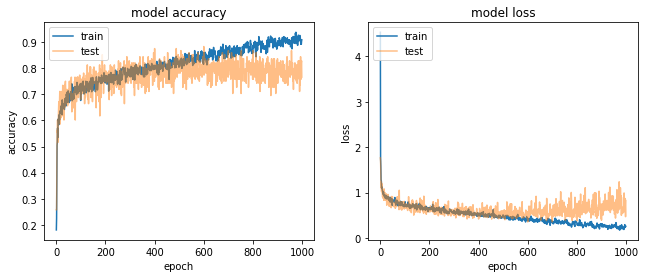

In [17]:
plt.subplot(1,2,1)
plt.plot(acc)
plt.plot(val_acc, alpha=0.5)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
plt.plot(loss)
plt.plot(val_loss, alpha=0.5)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplots_adjust(right=1.5)
plt.show()

### A few different model architectures have been tested but all yield the same results.  Clearly a generalization gap is occuring; more data is needed...

# 2.3 -- DATA AUGMENTATION

### Since this is audio data one does not want to perform transformations that would significantly change the frequency domain; the frequency portion of the data is most important in classification. However tranformations in the temporal domain should lead to greater generalization; i.e. whether a sound clip starts a fraction of a second later or earlier shouldn't change its category. 

In [8]:
def Data_Augment(data, threshold, h_shift_range):

    for i in range(len(data[0])):
        # Only apply         
        if np.random.random() < threshold:
            
            # Randomize horizontal shift within the specified range
            h_shift = np.random.randint(h_shift_range[0], h_shift_range[1]+1)
            
            # Apply horizontal shift to data
            data[i,:,:]=np.roll(np.squeeze(data[i,:,:]), h_shift, axis=1)
                                 
    return data

### The above function takes in a chunk of data and randomly applies a left or right horizontal shift to the data. The transformation is only applied when a randomly generated number between 0 and 1 is less than a given threshold. In this way the user can control how often to apply the transformations.

In [9]:
# Returns i-th chunk of X,y data at path.
def Data_Gen(X_path, y_path, mean_log_amplitude, threshold, h_shift_range):

    # X data
    file = open(pickle_path + "Spectra/" + X_path, "rb")
    X=pickle.load(file)
    file.close()            
       
    X = np.log(X) - mean_log_amplitude    
    X = Data_Augment(X, threshold, h_shift_range)
    X = np.stack((X,), -1) 
    
    
    # y data
    file = open(pickle_path + "Targets/" + y_path, "rb")
    y=pickle.load(file)
    file.close()
    
    y = keras.utils.np_utils.to_categorical(y)        
    
    return X,y

### Reinitialize model:

In [20]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(4, 4), strides=(1, 1), activation='relu', input_shape=(129,129,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(32, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

In [21]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Going to try threshold = 0.5, i.e., 50% of the time a horizontal shift will be applied. The shift range will be +/-30 'pixels' to the left or right, or about +/- 23% of the data.  

In [28]:
X_files = sorted(os.listdir(pickle_path + "Spectra"))
y_files = sorted(os.listdir(pickle_path + "Targets"))

num_chunks = len(y_files)
iteration = 0

acc=[]
loss=[]

val_loss=[]
val_acc=[]

num_epochs = 20

for _ in range(num_epochs):
    
    for X_file, y_file in zip(X_files,y_files):

        iteration +=1
        print('chunk number: ' + str(iteration) + " of " + str(num_chunks*num_epochs))

        X,y = Data_Gen(X_file, y_file, mean_log_amplitude, threshold = 0.5, h_shift_range=(-30,30))

        history=model.fit(X, y, batch_size=128, epochs=1, validation_split=1/8, verbose=2)

        val_acc.append(history.history['val_acc'])
        acc.append(history.history['acc'])
        
        loss.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        

    

chunk number: 1 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 4.3405 - acc: 0.1975 - val_loss: 1.7320 - val_acc: 0.3906
chunk number: 2 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.6632 - acc: 0.3906 - val_loss: 1.4107 - val_acc: 0.4766
chunk number: 3 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.3685 - acc: 0.4676 - val_loss: 1.3254 - val_acc: 0.4922
chunk number: 4 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.2127 - acc: 0.5033 - val_loss: 1.1030 - val_acc: 0.5703
chunk number: 5 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.2353 - acc: 0.4922 - val_loss: 1.2175 - val_acc: 0.5391
chunk number: 6 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.0746 - acc: 0.5792 - val_loss: 1.0764 - val_acc: 0.5234
chunk number: 7 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - 

chunk number: 55 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.8125 - acc: 0.6942 - val_loss: 0.7760 - val_acc: 0.6953
chunk number: 56 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.8583 - acc: 0.6797 - val_loss: 0.7509 - val_acc: 0.7578
chunk number: 57 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.8538 - acc: 0.6551 - val_loss: 0.7783 - val_acc: 0.7031
chunk number: 58 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7880 - acc: 0.7076 - val_loss: 0.6747 - val_acc: 0.7188
chunk number: 59 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7659 - acc: 0.7031 - val_loss: 0.7691 - val_acc: 0.7422
chunk number: 60 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.8802 - acc: 0.6473 - val_loss: 0.8576 - val_acc: 0.6797
chunk number: 61 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 

chunk number: 109 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6943 - acc: 0.7433 - val_loss: 0.6524 - val_acc: 0.7266
chunk number: 110 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7116 - acc: 0.7333 - val_loss: 0.7440 - val_acc: 0.7188
chunk number: 111 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7649 - acc: 0.7042 - val_loss: 0.7591 - val_acc: 0.7266
chunk number: 112 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7602 - acc: 0.6920 - val_loss: 0.6195 - val_acc: 0.7891
chunk number: 113 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7062 - acc: 0.7266 - val_loss: 0.7248 - val_acc: 0.7266
chunk number: 114 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7562 - acc: 0.7176 - val_loss: 0.6875 - val_acc: 0.7109
chunk number: 115 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 163 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7109 - acc: 0.7221 - val_loss: 0.7946 - val_acc: 0.7188
chunk number: 164 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6260 - acc: 0.7801 - val_loss: 0.7196 - val_acc: 0.7109
chunk number: 165 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7211 - acc: 0.7254 - val_loss: 0.6279 - val_acc: 0.7188
chunk number: 166 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7045 - acc: 0.7076 - val_loss: 0.6833 - val_acc: 0.7422
chunk number: 167 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7085 - acc: 0.7243 - val_loss: 0.6878 - val_acc: 0.7109
chunk number: 168 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7162 - acc: 0.7288 - val_loss: 0.7479 - val_acc: 0.7422
chunk number: 169 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 217 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6456 - acc: 0.7645 - val_loss: 0.5816 - val_acc: 0.8125
chunk number: 218 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6475 - acc: 0.7567 - val_loss: 0.6463 - val_acc: 0.7266
chunk number: 219 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6471 - acc: 0.7545 - val_loss: 0.6842 - val_acc: 0.6953
chunk number: 220 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6742 - acc: 0.7388 - val_loss: 0.6604 - val_acc: 0.7812
chunk number: 221 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6088 - acc: 0.7746 - val_loss: 0.6078 - val_acc: 0.7578
chunk number: 222 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6617 - acc: 0.7444 - val_loss: 0.7011 - val_acc: 0.7109
chunk number: 223 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 271 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5812 - acc: 0.7734 - val_loss: 0.6185 - val_acc: 0.7656
chunk number: 272 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6399 - acc: 0.7600 - val_loss: 0.7043 - val_acc: 0.7266
chunk number: 273 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5961 - acc: 0.7946 - val_loss: 0.6424 - val_acc: 0.7656
chunk number: 274 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6183 - acc: 0.7455 - val_loss: 0.7511 - val_acc: 0.7422
chunk number: 275 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6481 - acc: 0.7455 - val_loss: 0.5345 - val_acc: 0.7891
chunk number: 276 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5918 - acc: 0.7835 - val_loss: 0.5901 - val_acc: 0.7500
chunk number: 277 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 325 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5359 - acc: 0.7879 - val_loss: 0.5799 - val_acc: 0.8125
chunk number: 326 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5850 - acc: 0.7746 - val_loss: 0.6665 - val_acc: 0.7422
chunk number: 327 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5782 - acc: 0.7734 - val_loss: 0.4914 - val_acc: 0.8281
chunk number: 328 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5553 - acc: 0.7980 - val_loss: 0.6364 - val_acc: 0.7656
chunk number: 329 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5960 - acc: 0.7824 - val_loss: 0.5551 - val_acc: 0.7969
chunk number: 330 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5898 - acc: 0.7734 - val_loss: 0.7005 - val_acc: 0.7031
chunk number: 331 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 379 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5549 - acc: 0.7958 - val_loss: 0.4998 - val_acc: 0.7969
chunk number: 380 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5580 - acc: 0.7980 - val_loss: 0.5183 - val_acc: 0.8047
chunk number: 381 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5414 - acc: 0.7891 - val_loss: 0.5001 - val_acc: 0.8125
chunk number: 382 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5413 - acc: 0.7868 - val_loss: 0.4511 - val_acc: 0.8203
chunk number: 383 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5940 - acc: 0.7656 - val_loss: 0.5553 - val_acc: 0.7891
chunk number: 384 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5584 - acc: 0.7835 - val_loss: 0.5475 - val_acc: 0.7656
chunk number: 385 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 433 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5404 - acc: 0.7879 - val_loss: 0.5154 - val_acc: 0.7812
chunk number: 434 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5574 - acc: 0.7879 - val_loss: 0.5757 - val_acc: 0.7500
chunk number: 435 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5644 - acc: 0.7812 - val_loss: 0.6792 - val_acc: 0.7188
chunk number: 436 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5366 - acc: 0.7958 - val_loss: 0.4971 - val_acc: 0.7812
chunk number: 437 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5408 - acc: 0.8002 - val_loss: 0.4774 - val_acc: 0.8047
chunk number: 438 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5342 - acc: 0.8025 - val_loss: 0.6830 - val_acc: 0.7656
chunk number: 439 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 487 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5431 - acc: 0.8013 - val_loss: 0.5375 - val_acc: 0.7891
chunk number: 488 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5739 - acc: 0.7645 - val_loss: 0.4272 - val_acc: 0.8359
chunk number: 489 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5220 - acc: 0.8047 - val_loss: 0.4788 - val_acc: 0.8047
chunk number: 490 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5330 - acc: 0.8025 - val_loss: 0.5006 - val_acc: 0.8047
chunk number: 491 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5628 - acc: 0.7824 - val_loss: 0.5801 - val_acc: 0.8125
chunk number: 492 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5412 - acc: 0.7790 - val_loss: 0.4721 - val_acc: 0.8047
chunk number: 493 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 541 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4960 - acc: 0.8170 - val_loss: 0.4871 - val_acc: 0.8047
chunk number: 542 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5026 - acc: 0.8069 - val_loss: 0.5508 - val_acc: 0.7578
chunk number: 543 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4976 - acc: 0.8158 - val_loss: 0.4467 - val_acc: 0.8203
chunk number: 544 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4653 - acc: 0.8214 - val_loss: 0.5299 - val_acc: 0.7812
chunk number: 545 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5108 - acc: 0.7946 - val_loss: 0.4502 - val_acc: 0.8203
chunk number: 546 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5008 - acc: 0.8214 - val_loss: 0.6300 - val_acc: 0.7969
chunk number: 547 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 595 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4631 - acc: 0.8192 - val_loss: 0.4811 - val_acc: 0.8125
chunk number: 596 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5271 - acc: 0.7980 - val_loss: 0.4218 - val_acc: 0.8125
chunk number: 597 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4919 - acc: 0.8013 - val_loss: 0.4572 - val_acc: 0.8359
chunk number: 598 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5109 - acc: 0.8036 - val_loss: 0.4645 - val_acc: 0.8281
chunk number: 599 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4790 - acc: 0.8069 - val_loss: 0.4302 - val_acc: 0.8594
chunk number: 600 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4729 - acc: 0.8281 - val_loss: 0.4973 - val_acc: 0.8203
chunk number: 601 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 649 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5117 - acc: 0.8114 - val_loss: 0.5793 - val_acc: 0.8047
chunk number: 650 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5076 - acc: 0.8069 - val_loss: 0.5225 - val_acc: 0.8125
chunk number: 651 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4944 - acc: 0.7891 - val_loss: 0.5480 - val_acc: 0.7969
chunk number: 652 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4470 - acc: 0.8192 - val_loss: 0.4211 - val_acc: 0.8047
chunk number: 653 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5319 - acc: 0.7891 - val_loss: 0.5633 - val_acc: 0.7656
chunk number: 654 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4750 - acc: 0.8237 - val_loss: 0.4988 - val_acc: 0.8125
chunk number: 655 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 703 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4598 - acc: 0.8125 - val_loss: 0.5091 - val_acc: 0.8047
chunk number: 704 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4906 - acc: 0.8192 - val_loss: 0.4930 - val_acc: 0.8438
chunk number: 705 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5128 - acc: 0.8013 - val_loss: 0.5150 - val_acc: 0.8047
chunk number: 706 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4788 - acc: 0.8181 - val_loss: 0.6214 - val_acc: 0.7891
chunk number: 707 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5083 - acc: 0.8237 - val_loss: 0.5051 - val_acc: 0.7656
chunk number: 708 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4799 - acc: 0.8192 - val_loss: 0.4440 - val_acc: 0.8438
chunk number: 709 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 757 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4637 - acc: 0.8136 - val_loss: 0.4886 - val_acc: 0.8281
chunk number: 758 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4459 - acc: 0.8326 - val_loss: 0.4347 - val_acc: 0.8438
chunk number: 759 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4614 - acc: 0.8237 - val_loss: 0.5014 - val_acc: 0.8281
chunk number: 760 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5140 - acc: 0.8103 - val_loss: 0.6309 - val_acc: 0.7812
chunk number: 761 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5002 - acc: 0.8170 - val_loss: 0.4868 - val_acc: 0.7969
chunk number: 762 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4477 - acc: 0.8248 - val_loss: 0.3396 - val_acc: 0.8906
chunk number: 763 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 811 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4669 - acc: 0.8237 - val_loss: 0.4228 - val_acc: 0.8047
chunk number: 812 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4771 - acc: 0.8170 - val_loss: 0.5050 - val_acc: 0.7812
chunk number: 813 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4255 - acc: 0.8315 - val_loss: 0.5907 - val_acc: 0.7969
chunk number: 814 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4865 - acc: 0.8103 - val_loss: 0.4494 - val_acc: 0.8516
chunk number: 815 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4883 - acc: 0.8170 - val_loss: 0.5228 - val_acc: 0.7891
chunk number: 816 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4475 - acc: 0.8281 - val_loss: 0.6071 - val_acc: 0.7656
chunk number: 817 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 865 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4835 - acc: 0.8103 - val_loss: 0.5405 - val_acc: 0.8047
chunk number: 866 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4538 - acc: 0.8181 - val_loss: 0.5518 - val_acc: 0.7344
chunk number: 867 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4471 - acc: 0.8382 - val_loss: 0.5601 - val_acc: 0.7656
chunk number: 868 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4494 - acc: 0.8270 - val_loss: 0.6311 - val_acc: 0.7734
chunk number: 869 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5123 - acc: 0.8047 - val_loss: 0.5094 - val_acc: 0.8047
chunk number: 870 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4234 - acc: 0.8292 - val_loss: 0.5541 - val_acc: 0.7969
chunk number: 871 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 919 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4054 - acc: 0.8348 - val_loss: 0.4929 - val_acc: 0.7656
chunk number: 920 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4491 - acc: 0.8203 - val_loss: 0.5469 - val_acc: 0.7969
chunk number: 921 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4184 - acc: 0.8449 - val_loss: 0.4837 - val_acc: 0.7969
chunk number: 922 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4143 - acc: 0.8382 - val_loss: 0.4363 - val_acc: 0.8438
chunk number: 923 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3879 - acc: 0.8516 - val_loss: 0.4656 - val_acc: 0.8516
chunk number: 924 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4460 - acc: 0.8393 - val_loss: 0.4760 - val_acc: 0.7812
chunk number: 925 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 973 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3755 - acc: 0.8594 - val_loss: 0.6076 - val_acc: 0.7578
chunk number: 974 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4367 - acc: 0.8404 - val_loss: 0.5391 - val_acc: 0.7812
chunk number: 975 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4049 - acc: 0.8516 - val_loss: 0.4894 - val_acc: 0.8281
chunk number: 976 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3790 - acc: 0.8571 - val_loss: 0.6124 - val_acc: 0.7891
chunk number: 977 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3899 - acc: 0.8404 - val_loss: 0.5031 - val_acc: 0.8047
chunk number: 978 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3654 - acc: 0.8638 - val_loss: 0.6297 - val_acc: 0.7969
chunk number: 979 of 2000
Train on 896 samples, validate on 128 samples
Epoc

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4107 - acc: 0.8504 - val_loss: 0.5952 - val_acc: 0.7969
chunk number: 1027 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3789 - acc: 0.8527 - val_loss: 0.3691 - val_acc: 0.8438
chunk number: 1028 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3950 - acc: 0.8415 - val_loss: 0.5777 - val_acc: 0.8047
chunk number: 1029 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3911 - acc: 0.8571 - val_loss: 0.4605 - val_acc: 0.8203
chunk number: 1030 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4199 - acc: 0.8415 - val_loss: 0.4735 - val_acc: 0.8125
chunk number: 1031 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4398 - acc: 0.8382 - val_loss: 0.5673 - val_acc: 0.7891
chunk number: 1032 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3727 - acc: 0.8460 - val_loss: 0.3585 - val_acc: 0.8672
chunk number: 1080 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3838 - acc: 0.8583 - val_loss: 0.4248 - val_acc: 0.8672
chunk number: 1081 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3785 - acc: 0.8560 - val_loss: 0.3839 - val_acc: 0.8438
chunk number: 1082 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4127 - acc: 0.8471 - val_loss: 0.4728 - val_acc: 0.7734
chunk number: 1083 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4355 - acc: 0.8292 - val_loss: 0.4037 - val_acc: 0.8750
chunk number: 1084 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4095 - acc: 0.8471 - val_loss: 0.5136 - val_acc: 0.7656
chunk number: 1085 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4036 - acc: 0.8426 - val_loss: 0.5113 - val_acc: 0.7969
chunk number: 1133 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3968 - acc: 0.8583 - val_loss: 0.4171 - val_acc: 0.8281
chunk number: 1134 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3697 - acc: 0.8594 - val_loss: 0.5555 - val_acc: 0.8203
chunk number: 1135 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4094 - acc: 0.8538 - val_loss: 0.5171 - val_acc: 0.7656
chunk number: 1136 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4038 - acc: 0.8527 - val_loss: 0.4089 - val_acc: 0.8281
chunk number: 1137 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3875 - acc: 0.8348 - val_loss: 0.5013 - val_acc: 0.8047
chunk number: 1138 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4155 - acc: 0.8382 - val_loss: 0.4850 - val_acc: 0.8281
chunk number: 1186 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4117 - acc: 0.8493 - val_loss: 0.3879 - val_acc: 0.8594
chunk number: 1187 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4038 - acc: 0.8415 - val_loss: 0.4558 - val_acc: 0.7891
chunk number: 1188 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3816 - acc: 0.8438 - val_loss: 0.3954 - val_acc: 0.8516
chunk number: 1189 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3596 - acc: 0.8493 - val_loss: 0.4820 - val_acc: 0.7969
chunk number: 1190 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3744 - acc: 0.8583 - val_loss: 0.4579 - val_acc: 0.8281
chunk number: 1191 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3856 - acc: 0.8627 - val_loss: 0.4007 - val_acc: 0.8672
chunk number: 1239 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3678 - acc: 0.8571 - val_loss: 0.4837 - val_acc: 0.8281
chunk number: 1240 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4082 - acc: 0.8393 - val_loss: 0.5178 - val_acc: 0.7891
chunk number: 1241 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3437 - acc: 0.8694 - val_loss: 0.4941 - val_acc: 0.8125
chunk number: 1242 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3267 - acc: 0.8795 - val_loss: 0.5768 - val_acc: 0.7734
chunk number: 1243 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3356 - acc: 0.8661 - val_loss: 0.5292 - val_acc: 0.7812
chunk number: 1244 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3820 - acc: 0.8449 - val_loss: 0.5242 - val_acc: 0.8047
chunk number: 1292 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3983 - acc: 0.8438 - val_loss: 0.4823 - val_acc: 0.8516
chunk number: 1293 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2993 - acc: 0.8839 - val_loss: 0.5870 - val_acc: 0.7969
chunk number: 1294 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3821 - acc: 0.8616 - val_loss: 0.5183 - val_acc: 0.8047
chunk number: 1295 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3488 - acc: 0.8761 - val_loss: 0.4906 - val_acc: 0.8047
chunk number: 1296 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3623 - acc: 0.8605 - val_loss: 0.4606 - val_acc: 0.8281
chunk number: 1297 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3465 - acc: 0.8605 - val_loss: 0.5886 - val_acc: 0.8047
chunk number: 1345 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3408 - acc: 0.8661 - val_loss: 0.4350 - val_acc: 0.8516
chunk number: 1346 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3440 - acc: 0.8538 - val_loss: 0.7221 - val_acc: 0.7734
chunk number: 1347 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3434 - acc: 0.8471 - val_loss: 0.4883 - val_acc: 0.8281
chunk number: 1348 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3350 - acc: 0.8560 - val_loss: 0.6325 - val_acc: 0.7812
chunk number: 1349 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3260 - acc: 0.8705 - val_loss: 0.4178 - val_acc: 0.8516
chunk number: 1350 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3413 - acc: 0.8728 - val_loss: 0.3729 - val_acc: 0.8438
chunk number: 1398 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3525 - acc: 0.8504 - val_loss: 0.4987 - val_acc: 0.8203
chunk number: 1399 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3214 - acc: 0.8717 - val_loss: 0.3779 - val_acc: 0.8516
chunk number: 1400 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3358 - acc: 0.8761 - val_loss: 0.4568 - val_acc: 0.8203
chunk number: 1401 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3108 - acc: 0.8984 - val_loss: 0.3673 - val_acc: 0.8594
chunk number: 1402 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3321 - acc: 0.8739 - val_loss: 0.5684 - val_acc: 0.8203
chunk number: 1403 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3406 - acc: 0.8783 - val_loss: 0.5344 - val_acc: 0.8672
chunk number: 1451 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3382 - acc: 0.8594 - val_loss: 0.5175 - val_acc: 0.8203
chunk number: 1452 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3344 - acc: 0.8772 - val_loss: 0.3651 - val_acc: 0.8281
chunk number: 1453 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3674 - acc: 0.8504 - val_loss: 0.4460 - val_acc: 0.8203
chunk number: 1454 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3720 - acc: 0.8605 - val_loss: 0.3241 - val_acc: 0.8672
chunk number: 1455 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3716 - acc: 0.8661 - val_loss: 0.4475 - val_acc: 0.8125
chunk number: 1456 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3003 - acc: 0.8951 - val_loss: 0.4697 - val_acc: 0.7891
chunk number: 1504 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3022 - acc: 0.8750 - val_loss: 0.4827 - val_acc: 0.8828
chunk number: 1505 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3396 - acc: 0.8638 - val_loss: 0.5649 - val_acc: 0.7812
chunk number: 1506 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2630 - acc: 0.8984 - val_loss: 0.4991 - val_acc: 0.7969
chunk number: 1507 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3354 - acc: 0.8750 - val_loss: 0.5339 - val_acc: 0.7969
chunk number: 1508 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3274 - acc: 0.8783 - val_loss: 0.4085 - val_acc: 0.8516
chunk number: 1509 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3498 - acc: 0.8761 - val_loss: 0.4991 - val_acc: 0.7969
chunk number: 1557 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3463 - acc: 0.8739 - val_loss: 0.4542 - val_acc: 0.8359
chunk number: 1558 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3138 - acc: 0.8873 - val_loss: 0.4538 - val_acc: 0.8594
chunk number: 1559 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3373 - acc: 0.8817 - val_loss: 0.3936 - val_acc: 0.8125
chunk number: 1560 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3778 - acc: 0.8705 - val_loss: 0.5462 - val_acc: 0.8203
chunk number: 1561 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3112 - acc: 0.8895 - val_loss: 0.5258 - val_acc: 0.8281
chunk number: 1562 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2992 - acc: 0.8862 - val_loss: 0.3880 - val_acc: 0.8672
chunk number: 1610 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2893 - acc: 0.8895 - val_loss: 0.5640 - val_acc: 0.8125
chunk number: 1611 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3325 - acc: 0.8862 - val_loss: 0.4109 - val_acc: 0.8359
chunk number: 1612 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3653 - acc: 0.8717 - val_loss: 0.4353 - val_acc: 0.7891
chunk number: 1613 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3037 - acc: 0.8984 - val_loss: 0.7071 - val_acc: 0.8125
chunk number: 1614 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3197 - acc: 0.8806 - val_loss: 0.3414 - val_acc: 0.8984
chunk number: 1615 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3010 - acc: 0.8795 - val_loss: 0.2975 - val_acc: 0.8906
chunk number: 1663 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3742 - acc: 0.8605 - val_loss: 0.5460 - val_acc: 0.7656
chunk number: 1664 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2905 - acc: 0.8929 - val_loss: 0.4131 - val_acc: 0.7969
chunk number: 1665 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3249 - acc: 0.8638 - val_loss: 0.4023 - val_acc: 0.8281
chunk number: 1666 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3531 - acc: 0.8672 - val_loss: 0.4738 - val_acc: 0.7969
chunk number: 1667 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3023 - acc: 0.8895 - val_loss: 0.4823 - val_acc: 0.7891
chunk number: 1668 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3385 - acc: 0.8795 - val_loss: 0.4692 - val_acc: 0.8281
chunk number: 1716 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2992 - acc: 0.8873 - val_loss: 0.6012 - val_acc: 0.7812
chunk number: 1717 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3404 - acc: 0.8638 - val_loss: 0.5321 - val_acc: 0.7578
chunk number: 1718 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3532 - acc: 0.8828 - val_loss: 0.4041 - val_acc: 0.8203
chunk number: 1719 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3359 - acc: 0.8694 - val_loss: 0.4639 - val_acc: 0.7891
chunk number: 1720 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3050 - acc: 0.8839 - val_loss: 0.4701 - val_acc: 0.8828
chunk number: 1721 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2681 - acc: 0.8917 - val_loss: 0.6641 - val_acc: 0.7969
chunk number: 1769 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2839 - acc: 0.8884 - val_loss: 0.5001 - val_acc: 0.8438
chunk number: 1770 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3258 - acc: 0.8917 - val_loss: 0.5802 - val_acc: 0.7969
chunk number: 1771 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2974 - acc: 0.8884 - val_loss: 0.4203 - val_acc: 0.8359
chunk number: 1772 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3148 - acc: 0.8862 - val_loss: 0.6734 - val_acc: 0.7891
chunk number: 1773 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2781 - acc: 0.8996 - val_loss: 0.6781 - val_acc: 0.7812
chunk number: 1774 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2932 - acc: 0.8828 - val_loss: 0.4123 - val_acc: 0.8516
chunk number: 1822 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3359 - acc: 0.8806 - val_loss: 0.3712 - val_acc: 0.8359
chunk number: 1823 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2948 - acc: 0.8929 - val_loss: 0.4734 - val_acc: 0.8125
chunk number: 1824 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3140 - acc: 0.8862 - val_loss: 0.4941 - val_acc: 0.8047
chunk number: 1825 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2729 - acc: 0.9007 - val_loss: 0.4420 - val_acc: 0.8516
chunk number: 1826 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3161 - acc: 0.8917 - val_loss: 0.6134 - val_acc: 0.8516
chunk number: 1827 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3143 - acc: 0.8940 - val_loss: 0.4646 - val_acc: 0.7812
chunk number: 1875 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2824 - acc: 0.8873 - val_loss: 0.4277 - val_acc: 0.8516
chunk number: 1876 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2762 - acc: 0.8873 - val_loss: 0.5670 - val_acc: 0.8125
chunk number: 1877 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2814 - acc: 0.8895 - val_loss: 0.5104 - val_acc: 0.8281
chunk number: 1878 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2619 - acc: 0.9062 - val_loss: 0.7762 - val_acc: 0.7812
chunk number: 1879 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3240 - acc: 0.8828 - val_loss: 0.4260 - val_acc: 0.8203
chunk number: 1880 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2706 - acc: 0.8984 - val_loss: 0.3066 - val_acc: 0.8828
chunk number: 1928 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3189 - acc: 0.8850 - val_loss: 0.6328 - val_acc: 0.7969
chunk number: 1929 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2933 - acc: 0.8895 - val_loss: 0.4123 - val_acc: 0.8203
chunk number: 1930 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3387 - acc: 0.8594 - val_loss: 0.6903 - val_acc: 0.7969
chunk number: 1931 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2879 - acc: 0.8996 - val_loss: 0.5055 - val_acc: 0.8125
chunk number: 1932 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3024 - acc: 0.8973 - val_loss: 0.4055 - val_acc: 0.8438
chunk number: 1933 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2509 - acc: 0.9196 - val_loss: 0.4336 - val_acc: 0.8828
chunk number: 1981 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2579 - acc: 0.8984 - val_loss: 0.4025 - val_acc: 0.8516
chunk number: 1982 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3081 - acc: 0.8839 - val_loss: 0.3994 - val_acc: 0.8516
chunk number: 1983 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3314 - acc: 0.8750 - val_loss: 0.4829 - val_acc: 0.8203
chunk number: 1984 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2830 - acc: 0.8895 - val_loss: 0.5094 - val_acc: 0.7812
chunk number: 1985 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3059 - acc: 0.8895 - val_loss: 0.5864 - val_acc: 0.7969
chunk number: 1986 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

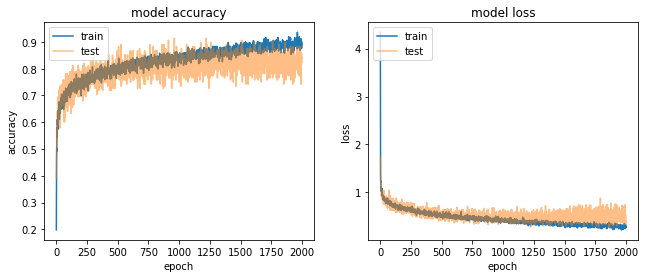

In [29]:
plt.subplot(1,2,1)
plt.plot(acc)
plt.plot(val_acc, alpha=0.5)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
plt.plot(loss)
plt.plot(val_loss, alpha=0.5)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplots_adjust(right=1.5)
plt.show()

### Much better than before, and at twice the epochs! Still room for improvement...

### Test: Do same as above but augment data 100% of the time.

In [30]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(4, 4), strides=(1, 1), activation='relu', input_shape=(129,129,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(32, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

In [31]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [33]:
X_files = sorted(os.listdir(pickle_path + "Spectra"))
y_files = sorted(os.listdir(pickle_path + "Targets"))

num_chunks = len(y_files)
iteration = 0

acc=[]
loss=[]

val_loss=[]
val_acc=[]

num_epochs = 20

for _ in range(num_epochs):
    
    for X_file, y_file in zip(X_files,y_files):

        iteration +=1
        print('chunk number: ' + str(iteration) + " of " + str(num_chunks*num_epochs))
        
        X,y = Data_Gen(X_file, y_file, mean_log_amplitude, threshold = 1.0, h_shift_range=(-30,30))

        history=model.fit(X, y, batch_size=128, epochs=1, validation_split=1/8, verbose=2)

        val_acc.append(history.history['val_acc'])
        acc.append(history.history['acc'])
        
        loss.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        

    

chunk number: 1 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 3.6287 - acc: 0.2087 - val_loss: 1.7268 - val_acc: 0.2656
chunk number: 2 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.5722 - acc: 0.3527 - val_loss: 1.2781 - val_acc: 0.4766
chunk number: 3 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.2681 - acc: 0.4554 - val_loss: 1.1969 - val_acc: 0.5547
chunk number: 4 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.1182 - acc: 0.5547 - val_loss: 1.0197 - val_acc: 0.6172
chunk number: 5 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.1794 - acc: 0.5324 - val_loss: 1.1574 - val_acc: 0.5469
chunk number: 6 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 1.0832 - acc: 0.5804 - val_loss: 0.9985 - val_acc: 0.5234
chunk number: 7 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - 

chunk number: 55 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7719 - acc: 0.6964 - val_loss: 0.7532 - val_acc: 0.6875
chunk number: 56 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7646 - acc: 0.6987 - val_loss: 0.6732 - val_acc: 0.7344
chunk number: 57 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7849 - acc: 0.6875 - val_loss: 0.6702 - val_acc: 0.7344
chunk number: 58 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7824 - acc: 0.6886 - val_loss: 0.6891 - val_acc: 0.7578
chunk number: 59 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7599 - acc: 0.7020 - val_loss: 0.7329 - val_acc: 0.7500
chunk number: 60 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.8647 - acc: 0.6730 - val_loss: 0.7301 - val_acc: 0.7188
chunk number: 61 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 

chunk number: 109 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6419 - acc: 0.7779 - val_loss: 0.6111 - val_acc: 0.7031
chunk number: 110 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6750 - acc: 0.7333 - val_loss: 0.6839 - val_acc: 0.7578
chunk number: 111 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7257 - acc: 0.7232 - val_loss: 0.7713 - val_acc: 0.7031
chunk number: 112 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7377 - acc: 0.7266 - val_loss: 0.5894 - val_acc: 0.7656
chunk number: 113 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6732 - acc: 0.7433 - val_loss: 0.7079 - val_acc: 0.7266
chunk number: 114 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.7234 - acc: 0.7243 - val_loss: 0.6336 - val_acc: 0.7891
chunk number: 115 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 163 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6428 - acc: 0.7455 - val_loss: 0.6632 - val_acc: 0.7266
chunk number: 164 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5399 - acc: 0.8114 - val_loss: 0.6542 - val_acc: 0.7656
chunk number: 165 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6600 - acc: 0.7556 - val_loss: 0.5277 - val_acc: 0.8125
chunk number: 166 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6436 - acc: 0.7467 - val_loss: 0.7414 - val_acc: 0.6875
chunk number: 167 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6021 - acc: 0.7690 - val_loss: 0.6067 - val_acc: 0.7812
chunk number: 168 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6493 - acc: 0.7500 - val_loss: 0.7246 - val_acc: 0.6953
chunk number: 169 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 217 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5705 - acc: 0.7779 - val_loss: 0.5503 - val_acc: 0.7891
chunk number: 218 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5662 - acc: 0.7891 - val_loss: 0.6572 - val_acc: 0.7734
chunk number: 219 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5620 - acc: 0.7891 - val_loss: 0.5981 - val_acc: 0.7500
chunk number: 220 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6133 - acc: 0.7734 - val_loss: 0.5945 - val_acc: 0.7812
chunk number: 221 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5422 - acc: 0.7824 - val_loss: 0.5161 - val_acc: 0.8203
chunk number: 222 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.6008 - acc: 0.7656 - val_loss: 0.5457 - val_acc: 0.7891
chunk number: 223 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 271 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5421 - acc: 0.7846 - val_loss: 0.5975 - val_acc: 0.7734
chunk number: 272 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5352 - acc: 0.7913 - val_loss: 0.5839 - val_acc: 0.8125
chunk number: 273 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4960 - acc: 0.8092 - val_loss: 0.5442 - val_acc: 0.8125
chunk number: 274 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5595 - acc: 0.7757 - val_loss: 0.7601 - val_acc: 0.7188
chunk number: 275 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5503 - acc: 0.7924 - val_loss: 0.4513 - val_acc: 0.8516
chunk number: 276 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4852 - acc: 0.8292 - val_loss: 0.6389 - val_acc: 0.7500
chunk number: 277 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 325 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4663 - acc: 0.8181 - val_loss: 0.6020 - val_acc: 0.7656
chunk number: 326 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5328 - acc: 0.7913 - val_loss: 0.5322 - val_acc: 0.7969
chunk number: 327 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5120 - acc: 0.8125 - val_loss: 0.4279 - val_acc: 0.8281
chunk number: 328 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4871 - acc: 0.8092 - val_loss: 0.6284 - val_acc: 0.7422
chunk number: 329 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5223 - acc: 0.8069 - val_loss: 0.4819 - val_acc: 0.8125
chunk number: 330 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5433 - acc: 0.7969 - val_loss: 0.6141 - val_acc: 0.7500
chunk number: 331 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 379 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5041 - acc: 0.8013 - val_loss: 0.4754 - val_acc: 0.7969
chunk number: 380 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4652 - acc: 0.8181 - val_loss: 0.4851 - val_acc: 0.8281
chunk number: 381 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5011 - acc: 0.8036 - val_loss: 0.4496 - val_acc: 0.8203
chunk number: 382 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5071 - acc: 0.8181 - val_loss: 0.4696 - val_acc: 0.7969
chunk number: 383 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5316 - acc: 0.7824 - val_loss: 0.5306 - val_acc: 0.7969
chunk number: 384 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5012 - acc: 0.8002 - val_loss: 0.4728 - val_acc: 0.7656
chunk number: 385 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 433 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4968 - acc: 0.8013 - val_loss: 0.4343 - val_acc: 0.8047
chunk number: 434 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4997 - acc: 0.8047 - val_loss: 0.5167 - val_acc: 0.7891
chunk number: 435 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4511 - acc: 0.8326 - val_loss: 0.5957 - val_acc: 0.7969
chunk number: 436 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.5151 - acc: 0.8069 - val_loss: 0.5002 - val_acc: 0.7812
chunk number: 437 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4842 - acc: 0.8158 - val_loss: 0.3711 - val_acc: 0.8750
chunk number: 438 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4601 - acc: 0.8304 - val_loss: 0.5565 - val_acc: 0.8516
chunk number: 439 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 487 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4757 - acc: 0.8281 - val_loss: 0.5680 - val_acc: 0.7656
chunk number: 488 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4962 - acc: 0.8103 - val_loss: 0.3958 - val_acc: 0.8516
chunk number: 489 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4539 - acc: 0.8259 - val_loss: 0.4339 - val_acc: 0.8359
chunk number: 490 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4355 - acc: 0.8281 - val_loss: 0.5018 - val_acc: 0.8203
chunk number: 491 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4812 - acc: 0.8125 - val_loss: 0.5492 - val_acc: 0.8203
chunk number: 492 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4703 - acc: 0.8069 - val_loss: 0.3687 - val_acc: 0.8047
chunk number: 493 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 541 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4246 - acc: 0.8382 - val_loss: 0.4623 - val_acc: 0.8125
chunk number: 542 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4335 - acc: 0.8404 - val_loss: 0.5198 - val_acc: 0.8047
chunk number: 543 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4113 - acc: 0.8348 - val_loss: 0.4328 - val_acc: 0.7891
chunk number: 544 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4332 - acc: 0.8281 - val_loss: 0.6070 - val_acc: 0.7891
chunk number: 545 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4379 - acc: 0.8270 - val_loss: 0.5331 - val_acc: 0.7578
chunk number: 546 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4669 - acc: 0.8170 - val_loss: 0.4579 - val_acc: 0.8594
chunk number: 547 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 595 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4049 - acc: 0.8605 - val_loss: 0.3674 - val_acc: 0.8672
chunk number: 596 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4351 - acc: 0.8404 - val_loss: 0.4188 - val_acc: 0.8516
chunk number: 597 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4173 - acc: 0.8348 - val_loss: 0.3886 - val_acc: 0.8359
chunk number: 598 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4393 - acc: 0.8326 - val_loss: 0.4388 - val_acc: 0.8203
chunk number: 599 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3861 - acc: 0.8482 - val_loss: 0.4555 - val_acc: 0.8047
chunk number: 600 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4543 - acc: 0.8136 - val_loss: 0.3545 - val_acc: 0.8516
chunk number: 601 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 649 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4019 - acc: 0.8237 - val_loss: 0.5235 - val_acc: 0.8047
chunk number: 650 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4492 - acc: 0.8181 - val_loss: 0.4627 - val_acc: 0.8516
chunk number: 651 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4102 - acc: 0.8359 - val_loss: 0.4678 - val_acc: 0.8359
chunk number: 652 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4292 - acc: 0.8426 - val_loss: 0.3446 - val_acc: 0.8906
chunk number: 653 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4522 - acc: 0.8270 - val_loss: 0.4832 - val_acc: 0.8438
chunk number: 654 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4330 - acc: 0.8304 - val_loss: 0.3588 - val_acc: 0.8750
chunk number: 655 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 703 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4414 - acc: 0.8203 - val_loss: 0.3849 - val_acc: 0.8438
chunk number: 704 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4173 - acc: 0.8393 - val_loss: 0.4384 - val_acc: 0.8281
chunk number: 705 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4472 - acc: 0.8270 - val_loss: 0.5929 - val_acc: 0.7969
chunk number: 706 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3878 - acc: 0.8493 - val_loss: 0.5157 - val_acc: 0.8203
chunk number: 707 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4469 - acc: 0.8438 - val_loss: 0.4464 - val_acc: 0.8594
chunk number: 708 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3955 - acc: 0.8415 - val_loss: 0.3601 - val_acc: 0.8516
chunk number: 709 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 757 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4258 - acc: 0.8292 - val_loss: 0.4324 - val_acc: 0.8516
chunk number: 758 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3944 - acc: 0.8560 - val_loss: 0.4382 - val_acc: 0.8438
chunk number: 759 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4258 - acc: 0.8371 - val_loss: 0.3680 - val_acc: 0.8906
chunk number: 760 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4462 - acc: 0.8270 - val_loss: 0.4751 - val_acc: 0.8516
chunk number: 761 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4279 - acc: 0.8426 - val_loss: 0.3553 - val_acc: 0.8750
chunk number: 762 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3955 - acc: 0.8571 - val_loss: 0.3527 - val_acc: 0.8750
chunk number: 763 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 811 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4290 - acc: 0.8281 - val_loss: 0.3420 - val_acc: 0.8594
chunk number: 812 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4201 - acc: 0.8270 - val_loss: 0.4192 - val_acc: 0.8516
chunk number: 813 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3819 - acc: 0.8594 - val_loss: 0.5673 - val_acc: 0.8125
chunk number: 814 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4717 - acc: 0.8237 - val_loss: 0.3351 - val_acc: 0.8750
chunk number: 815 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4316 - acc: 0.8371 - val_loss: 0.4383 - val_acc: 0.8281
chunk number: 816 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3566 - acc: 0.8560 - val_loss: 0.6359 - val_acc: 0.7500
chunk number: 817 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 865 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4267 - acc: 0.8270 - val_loss: 0.3987 - val_acc: 0.8281
chunk number: 866 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4070 - acc: 0.8516 - val_loss: 0.4472 - val_acc: 0.8203
chunk number: 867 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3834 - acc: 0.8661 - val_loss: 0.4837 - val_acc: 0.7969
chunk number: 868 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4190 - acc: 0.8304 - val_loss: 0.5665 - val_acc: 0.8203
chunk number: 869 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4071 - acc: 0.8438 - val_loss: 0.3914 - val_acc: 0.8672
chunk number: 870 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3572 - acc: 0.8728 - val_loss: 0.4826 - val_acc: 0.7969
chunk number: 871 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 919 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3834 - acc: 0.8627 - val_loss: 0.4620 - val_acc: 0.7891
chunk number: 920 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4100 - acc: 0.8359 - val_loss: 0.4500 - val_acc: 0.8516
chunk number: 921 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3683 - acc: 0.8516 - val_loss: 0.4654 - val_acc: 0.8281
chunk number: 922 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3800 - acc: 0.8471 - val_loss: 0.4604 - val_acc: 0.8125
chunk number: 923 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3983 - acc: 0.8527 - val_loss: 0.4160 - val_acc: 0.8672
chunk number: 924 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4076 - acc: 0.8460 - val_loss: 0.4701 - val_acc: 0.8359
chunk number: 925 of 2000
Train on 896 samples, validate on 128 samples
Epoc

chunk number: 973 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3824 - acc: 0.8694 - val_loss: 0.5499 - val_acc: 0.8281
chunk number: 974 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4101 - acc: 0.8449 - val_loss: 0.5472 - val_acc: 0.7812
chunk number: 975 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3815 - acc: 0.8594 - val_loss: 0.4129 - val_acc: 0.8047
chunk number: 976 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3522 - acc: 0.8583 - val_loss: 0.4480 - val_acc: 0.8281
chunk number: 977 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3304 - acc: 0.8683 - val_loss: 0.4181 - val_acc: 0.7891
chunk number: 978 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3699 - acc: 0.8560 - val_loss: 0.5257 - val_acc: 0.7891
chunk number: 979 of 2000
Train on 896 samples, validate on 128 samples
Epoc

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4062 - acc: 0.8326 - val_loss: 0.4585 - val_acc: 0.8359
chunk number: 1027 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3874 - acc: 0.8337 - val_loss: 0.3307 - val_acc: 0.8516
chunk number: 1028 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3810 - acc: 0.8482 - val_loss: 0.5131 - val_acc: 0.8281
chunk number: 1029 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4037 - acc: 0.8504 - val_loss: 0.4450 - val_acc: 0.8516
chunk number: 1030 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3770 - acc: 0.8627 - val_loss: 0.5703 - val_acc: 0.7734
chunk number: 1031 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3814 - acc: 0.8594 - val_loss: 0.4362 - val_acc: 0.8516
chunk number: 1032 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3559 - acc: 0.8583 - val_loss: 0.3740 - val_acc: 0.8984
chunk number: 1080 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3616 - acc: 0.8627 - val_loss: 0.3574 - val_acc: 0.8828
chunk number: 1081 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3809 - acc: 0.8571 - val_loss: 0.3541 - val_acc: 0.8750
chunk number: 1082 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3763 - acc: 0.8538 - val_loss: 0.3380 - val_acc: 0.8672
chunk number: 1083 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3470 - acc: 0.8571 - val_loss: 0.4980 - val_acc: 0.8047
chunk number: 1084 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3553 - acc: 0.8672 - val_loss: 0.3870 - val_acc: 0.8203
chunk number: 1085 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4108 - acc: 0.8404 - val_loss: 0.5023 - val_acc: 0.8281
chunk number: 1133 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.4069 - acc: 0.8404 - val_loss: 0.3979 - val_acc: 0.8828
chunk number: 1134 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3772 - acc: 0.8482 - val_loss: 0.5141 - val_acc: 0.7969
chunk number: 1135 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3303 - acc: 0.8739 - val_loss: 0.4951 - val_acc: 0.7969
chunk number: 1136 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3496 - acc: 0.8583 - val_loss: 0.3993 - val_acc: 0.8516
chunk number: 1137 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3649 - acc: 0.8516 - val_loss: 0.3103 - val_acc: 0.8906
chunk number: 1138 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3881 - acc: 0.8627 - val_loss: 0.4511 - val_acc: 0.8281
chunk number: 1186 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3847 - acc: 0.8504 - val_loss: 0.3985 - val_acc: 0.8516
chunk number: 1187 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3729 - acc: 0.8672 - val_loss: 0.4872 - val_acc: 0.8125
chunk number: 1188 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3618 - acc: 0.8549 - val_loss: 0.3527 - val_acc: 0.8828
chunk number: 1189 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3478 - acc: 0.8672 - val_loss: 0.3920 - val_acc: 0.8359
chunk number: 1190 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3235 - acc: 0.8650 - val_loss: 0.3827 - val_acc: 0.8672
chunk number: 1191 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3416 - acc: 0.8560 - val_loss: 0.5071 - val_acc: 0.8516
chunk number: 1239 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3746 - acc: 0.8627 - val_loss: 0.4114 - val_acc: 0.8125
chunk number: 1240 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3923 - acc: 0.8482 - val_loss: 0.4164 - val_acc: 0.8047
chunk number: 1241 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3351 - acc: 0.8638 - val_loss: 0.3697 - val_acc: 0.8281
chunk number: 1242 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3426 - acc: 0.8806 - val_loss: 0.4785 - val_acc: 0.8359
chunk number: 1243 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3521 - acc: 0.8560 - val_loss: 0.4346 - val_acc: 0.8672
chunk number: 1244 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3275 - acc: 0.8783 - val_loss: 0.5902 - val_acc: 0.8281
chunk number: 1292 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3611 - acc: 0.8672 - val_loss: 0.3173 - val_acc: 0.8516
chunk number: 1293 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3417 - acc: 0.8638 - val_loss: 0.6651 - val_acc: 0.8125
chunk number: 1294 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3259 - acc: 0.8705 - val_loss: 0.3760 - val_acc: 0.8281
chunk number: 1295 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3019 - acc: 0.8795 - val_loss: 0.3672 - val_acc: 0.8594
chunk number: 1296 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3913 - acc: 0.8694 - val_loss: 0.4355 - val_acc: 0.8359
chunk number: 1297 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3359 - acc: 0.8772 - val_loss: 0.6095 - val_acc: 0.8047
chunk number: 1345 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3436 - acc: 0.8694 - val_loss: 0.4013 - val_acc: 0.8516
chunk number: 1346 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3717 - acc: 0.8493 - val_loss: 0.4809 - val_acc: 0.8516
chunk number: 1347 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3133 - acc: 0.8694 - val_loss: 0.3856 - val_acc: 0.8672
chunk number: 1348 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3409 - acc: 0.8605 - val_loss: 0.5392 - val_acc: 0.7812
chunk number: 1349 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3356 - acc: 0.8717 - val_loss: 0.4323 - val_acc: 0.8438
chunk number: 1350 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3204 - acc: 0.8694 - val_loss: 0.3934 - val_acc: 0.8516
chunk number: 1398 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3797 - acc: 0.8560 - val_loss: 0.4077 - val_acc: 0.8672
chunk number: 1399 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3396 - acc: 0.8694 - val_loss: 0.4633 - val_acc: 0.8047
chunk number: 1400 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3810 - acc: 0.8471 - val_loss: 0.2894 - val_acc: 0.8828
chunk number: 1401 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3165 - acc: 0.8806 - val_loss: 0.3429 - val_acc: 0.8672
chunk number: 1402 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3446 - acc: 0.8594 - val_loss: 0.5618 - val_acc: 0.7656
chunk number: 1403 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3376 - acc: 0.8750 - val_loss: 0.4625 - val_acc: 0.8516
chunk number: 1451 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3390 - acc: 0.8650 - val_loss: 0.4705 - val_acc: 0.8594
chunk number: 1452 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3216 - acc: 0.8795 - val_loss: 0.3052 - val_acc: 0.8906
chunk number: 1453 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3599 - acc: 0.8583 - val_loss: 0.5060 - val_acc: 0.8203
chunk number: 1454 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3370 - acc: 0.8717 - val_loss: 0.3575 - val_acc: 0.8438
chunk number: 1455 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3144 - acc: 0.8750 - val_loss: 0.3916 - val_acc: 0.8125
chunk number: 1456 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3357 - acc: 0.8750 - val_loss: 0.3865 - val_acc: 0.8594
chunk number: 1504 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3247 - acc: 0.8739 - val_loss: 0.3411 - val_acc: 0.8984
chunk number: 1505 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3393 - acc: 0.8728 - val_loss: 0.4119 - val_acc: 0.8516
chunk number: 1506 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3025 - acc: 0.8862 - val_loss: 0.4491 - val_acc: 0.8594
chunk number: 1507 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3454 - acc: 0.8728 - val_loss: 0.3208 - val_acc: 0.8828
chunk number: 1508 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3378 - acc: 0.8638 - val_loss: 0.3340 - val_acc: 0.8438
chunk number: 1509 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3443 - acc: 0.8717 - val_loss: 0.5301 - val_acc: 0.8203
chunk number: 1557 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3175 - acc: 0.8806 - val_loss: 0.4006 - val_acc: 0.8438
chunk number: 1558 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2893 - acc: 0.8895 - val_loss: 0.3042 - val_acc: 0.8750
chunk number: 1559 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3102 - acc: 0.8862 - val_loss: 0.3758 - val_acc: 0.8516
chunk number: 1560 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3704 - acc: 0.8627 - val_loss: 0.4531 - val_acc: 0.8594
chunk number: 1561 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3583 - acc: 0.8705 - val_loss: 0.2824 - val_acc: 0.9141
chunk number: 1562 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2960 - acc: 0.8828 - val_loss: 0.4568 - val_acc: 0.8281
chunk number: 1610 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3484 - acc: 0.8672 - val_loss: 0.4319 - val_acc: 0.8359
chunk number: 1611 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3882 - acc: 0.8504 - val_loss: 0.3813 - val_acc: 0.8516
chunk number: 1612 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3291 - acc: 0.8761 - val_loss: 0.4684 - val_acc: 0.8438
chunk number: 1613 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3330 - acc: 0.8739 - val_loss: 0.5078 - val_acc: 0.8125
chunk number: 1614 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3381 - acc: 0.8683 - val_loss: 0.3705 - val_acc: 0.8828
chunk number: 1615 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3296 - acc: 0.8761 - val_loss: 0.3148 - val_acc: 0.8906
chunk number: 1663 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3427 - acc: 0.8694 - val_loss: 0.4105 - val_acc: 0.8281
chunk number: 1664 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2857 - acc: 0.8873 - val_loss: 0.6525 - val_acc: 0.7656
chunk number: 1665 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3267 - acc: 0.8817 - val_loss: 0.3124 - val_acc: 0.8984
chunk number: 1666 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3195 - acc: 0.8739 - val_loss: 0.3825 - val_acc: 0.8438
chunk number: 1667 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2911 - acc: 0.9029 - val_loss: 0.4057 - val_acc: 0.8125
chunk number: 1668 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3462 - acc: 0.8683 - val_loss: 0.3555 - val_acc: 0.8516
chunk number: 1716 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3110 - acc: 0.8717 - val_loss: 0.5784 - val_acc: 0.8047
chunk number: 1717 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3690 - acc: 0.8516 - val_loss: 0.5192 - val_acc: 0.8203
chunk number: 1718 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3487 - acc: 0.8616 - val_loss: 0.5829 - val_acc: 0.7656
chunk number: 1719 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3015 - acc: 0.8862 - val_loss: 0.4636 - val_acc: 0.7500
chunk number: 1720 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3682 - acc: 0.8571 - val_loss: 0.4658 - val_acc: 0.8516
chunk number: 1721 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3682 - acc: 0.8605 - val_loss: 0.5866 - val_acc: 0.8203
chunk number: 1769 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3515 - acc: 0.8549 - val_loss: 0.4203 - val_acc: 0.8359
chunk number: 1770 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2939 - acc: 0.8828 - val_loss: 0.4673 - val_acc: 0.8438
chunk number: 1771 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3024 - acc: 0.8873 - val_loss: 0.5690 - val_acc: 0.7891
chunk number: 1772 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3285 - acc: 0.8862 - val_loss: 0.4876 - val_acc: 0.7969
chunk number: 1773 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3034 - acc: 0.8795 - val_loss: 0.4820 - val_acc: 0.8203
chunk number: 1774 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2868 - acc: 0.8862 - val_loss: 0.3924 - val_acc: 0.8828
chunk number: 1822 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2963 - acc: 0.8828 - val_loss: 0.3898 - val_acc: 0.8594
chunk number: 1823 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3411 - acc: 0.8750 - val_loss: 0.3258 - val_acc: 0.8828
chunk number: 1824 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3217 - acc: 0.8783 - val_loss: 0.4734 - val_acc: 0.8203
chunk number: 1825 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3126 - acc: 0.8817 - val_loss: 0.3346 - val_acc: 0.8594
chunk number: 1826 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3254 - acc: 0.8750 - val_loss: 0.5614 - val_acc: 0.7969
chunk number: 1827 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3544 - acc: 0.8728 - val_loss: 0.5463 - val_acc: 0.7656
chunk number: 1875 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3180 - acc: 0.8728 - val_loss: 0.4151 - val_acc: 0.8906
chunk number: 1876 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3003 - acc: 0.8884 - val_loss: 0.4126 - val_acc: 0.8594
chunk number: 1877 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2816 - acc: 0.8929 - val_loss: 0.4056 - val_acc: 0.8359
chunk number: 1878 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3537 - acc: 0.8638 - val_loss: 0.5678 - val_acc: 0.8281
chunk number: 1879 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3343 - acc: 0.8772 - val_loss: 0.3120 - val_acc: 0.8984
chunk number: 1880 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3063 - acc: 0.8828 - val_loss: 0.3742 - val_acc: 0.8672
chunk number: 1928 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2900 - acc: 0.8783 - val_loss: 0.4068 - val_acc: 0.8672
chunk number: 1929 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3032 - acc: 0.8806 - val_loss: 0.4919 - val_acc: 0.8750
chunk number: 1930 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3367 - acc: 0.8761 - val_loss: 0.4634 - val_acc: 0.8281
chunk number: 1931 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2813 - acc: 0.9029 - val_loss: 0.3790 - val_acc: 0.8516
chunk number: 1932 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3206 - acc: 0.8862 - val_loss: 0.4038 - val_acc: 0.8672
chunk number: 1933 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2907 - acc: 0.8984 - val_loss: 0.4061 - val_acc: 0.8906
chunk number: 1981 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3146 - acc: 0.8817 - val_loss: 0.3933 - val_acc: 0.8516
chunk number: 1982 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3175 - acc: 0.8750 - val_loss: 0.3150 - val_acc: 0.8750
chunk number: 1983 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2911 - acc: 0.8850 - val_loss: 0.4107 - val_acc: 0.8359
chunk number: 1984 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.2782 - acc: 0.8917 - val_loss: 0.3658 - val_acc: 0.8438
chunk number: 1985 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 0.3028 - acc: 0.8962 - val_loss: 0.4337 - val_acc: 0.8594
chunk number: 1986 of 2000
Train on 896 samples, validate on 128 samples
Epoch 1/1
 - 0s - loss: 

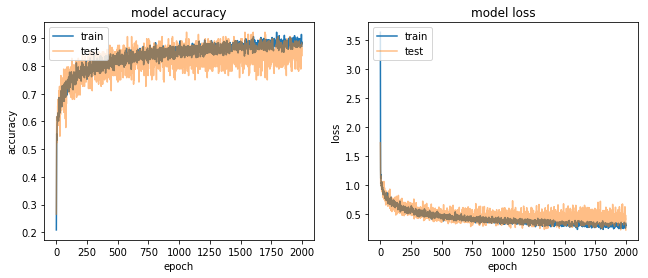

In [34]:
plt.subplot(1,2,1)
plt.plot(acc)
plt.plot(val_acc, alpha=0.5)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
plt.plot(loss)
plt.plot(val_loss, alpha=0.5)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplots_adjust(right=1.5)
plt.show()

In [35]:
model.save("Model/Scratch_Aug_1_hrange_pm20_v2.h5")

###  The above figures show improvement in the training-test data generalization gap. The model has only been given 87.5% of the total dataset. Below training is applied the same reinitialized model with no validation split. 

# 2.4 -- Full train

### Reinitialize + re-train model...

In [14]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(4, 4), strides=(1, 1), activation='relu', input_shape=(129,129,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(32, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

In [15]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [16]:
X_files = sorted(os.listdir(pickle_path + "Spectra"))
y_files = sorted(os.listdir(pickle_path + "Targets"))

num_chunks = len(y_files)
iteration = 0

acc=[]
loss=[]


num_epochs = 30

for _ in range(num_epochs):
    
    for X_file, y_file in zip(X_files,y_files):

        iteration +=1
        print('chunk number: ' + str(iteration) + " of " + str(num_chunks*num_epochs))
        
        X,y = Data_Gen(X_file, y_file, mean_log_amplitude, threshold = 1.0, h_shift_range=(-30,30))

        history=model.fit(X, y, batch_size=128, epochs=1, validation_split=0, verbose=2)

        acc.append(history.history['acc'])
        loss.append(history.history['loss'])
        

chunk number: 1 of 3000
Epoch 1/1
 - 0s - loss: 3.7283 - acc: 0.2979
chunk number: 2 of 3000
Epoch 1/1
 - 0s - loss: 1.5431 - acc: 0.3623
chunk number: 3 of 3000
Epoch 1/1
 - 0s - loss: 1.2734 - acc: 0.4727
chunk number: 4 of 3000
Epoch 1/1
 - 0s - loss: 1.1335 - acc: 0.5557
chunk number: 5 of 3000
Epoch 1/1
 - 0s - loss: 1.2032 - acc: 0.5322
chunk number: 6 of 3000
Epoch 1/1
 - 0s - loss: 1.0640 - acc: 0.5674
chunk number: 7 of 3000
Epoch 1/1
 - 0s - loss: 1.0313 - acc: 0.5986
chunk number: 8 of 3000
Epoch 1/1
 - 0s - loss: 1.0325 - acc: 0.6084
chunk number: 9 of 3000
Epoch 1/1
 - 0s - loss: 0.9763 - acc: 0.6328
chunk number: 10 of 3000
Epoch 1/1
 - 0s - loss: 1.0078 - acc: 0.5996
chunk number: 11 of 3000
Epoch 1/1
 - 0s - loss: 1.0013 - acc: 0.6025
chunk number: 12 of 3000
Epoch 1/1
 - 0s - loss: 0.9589 - acc: 0.6240
chunk number: 13 of 3000
Epoch 1/1
 - 0s - loss: 0.9484 - acc: 0.6211
chunk number: 14 of 3000
Epoch 1/1
 - 0s - loss: 0.9706 - acc: 0.6289
chunk number: 15 of 3000
Epoc

chunk number: 118 of 3000
Epoch 1/1
 - 0s - loss: 0.6831 - acc: 0.7305
chunk number: 119 of 3000
Epoch 1/1
 - 0s - loss: 0.6715 - acc: 0.7412
chunk number: 120 of 3000
Epoch 1/1
 - 0s - loss: 0.7163 - acc: 0.7217
chunk number: 121 of 3000
Epoch 1/1
 - 0s - loss: 0.6125 - acc: 0.7529
chunk number: 122 of 3000
Epoch 1/1
 - 0s - loss: 0.7042 - acc: 0.7363
chunk number: 123 of 3000
Epoch 1/1
 - 0s - loss: 0.6259 - acc: 0.7637
chunk number: 124 of 3000
Epoch 1/1
 - 0s - loss: 0.6636 - acc: 0.7432
chunk number: 125 of 3000
Epoch 1/1
 - 0s - loss: 0.6344 - acc: 0.7539
chunk number: 126 of 3000
Epoch 1/1
 - 0s - loss: 0.6591 - acc: 0.7383
chunk number: 127 of 3000
Epoch 1/1
 - 0s - loss: 0.6510 - acc: 0.7432
chunk number: 128 of 3000
Epoch 1/1
 - 0s - loss: 0.6723 - acc: 0.7412
chunk number: 129 of 3000
Epoch 1/1
 - 0s - loss: 0.6783 - acc: 0.7490
chunk number: 130 of 3000
Epoch 1/1
 - 0s - loss: 0.7429 - acc: 0.7236
chunk number: 131 of 3000
Epoch 1/1
 - 0s - loss: 0.6810 - acc: 0.7354
chunk 

chunk number: 234 of 3000
Epoch 1/1
 - 0s - loss: 0.6059 - acc: 0.7637
chunk number: 235 of 3000
Epoch 1/1
 - 0s - loss: 0.5686 - acc: 0.7930
chunk number: 236 of 3000
Epoch 1/1
 - 0s - loss: 0.5700 - acc: 0.7812
chunk number: 237 of 3000
Epoch 1/1
 - 0s - loss: 0.5392 - acc: 0.8008
chunk number: 238 of 3000
Epoch 1/1
 - 0s - loss: 0.5316 - acc: 0.8037
chunk number: 239 of 3000
Epoch 1/1
 - 0s - loss: 0.5621 - acc: 0.7910
chunk number: 240 of 3000
Epoch 1/1
 - 0s - loss: 0.6128 - acc: 0.7725
chunk number: 241 of 3000
Epoch 1/1
 - 0s - loss: 0.5234 - acc: 0.7998
chunk number: 242 of 3000
Epoch 1/1
 - 0s - loss: 0.5896 - acc: 0.7812
chunk number: 243 of 3000
Epoch 1/1
 - 0s - loss: 0.5397 - acc: 0.7881
chunk number: 244 of 3000
Epoch 1/1
 - 0s - loss: 0.5238 - acc: 0.8154
chunk number: 245 of 3000
Epoch 1/1
 - 0s - loss: 0.5607 - acc: 0.7920
chunk number: 246 of 3000
Epoch 1/1
 - 0s - loss: 0.5936 - acc: 0.7812
chunk number: 247 of 3000
Epoch 1/1
 - 0s - loss: 0.5473 - acc: 0.7910
chunk 

chunk number: 350 of 3000
Epoch 1/1
 - 0s - loss: 0.5274 - acc: 0.7871
chunk number: 351 of 3000
Epoch 1/1
 - 0s - loss: 0.5265 - acc: 0.7852
chunk number: 352 of 3000
Epoch 1/1
 - 0s - loss: 0.5212 - acc: 0.7988
chunk number: 353 of 3000
Epoch 1/1
 - 0s - loss: 0.5672 - acc: 0.7812
chunk number: 354 of 3000
Epoch 1/1
 - 0s - loss: 0.5176 - acc: 0.8076
chunk number: 355 of 3000
Epoch 1/1
 - 0s - loss: 0.5186 - acc: 0.8066
chunk number: 356 of 3000
Epoch 1/1
 - 0s - loss: 0.5693 - acc: 0.7891
chunk number: 357 of 3000
Epoch 1/1
 - 0s - loss: 0.5496 - acc: 0.7891
chunk number: 358 of 3000
Epoch 1/1
 - 0s - loss: 0.4778 - acc: 0.8193
chunk number: 359 of 3000
Epoch 1/1
 - 0s - loss: 0.5475 - acc: 0.7939
chunk number: 360 of 3000
Epoch 1/1
 - 0s - loss: 0.5944 - acc: 0.7764
chunk number: 361 of 3000
Epoch 1/1
 - 0s - loss: 0.5538 - acc: 0.8027
chunk number: 362 of 3000
Epoch 1/1
 - 0s - loss: 0.5353 - acc: 0.8018
chunk number: 363 of 3000
Epoch 1/1
 - 0s - loss: 0.5790 - acc: 0.7617
chunk 

chunk number: 466 of 3000
Epoch 1/1
 - 0s - loss: 0.5185 - acc: 0.7959
chunk number: 467 of 3000
Epoch 1/1
 - 0s - loss: 0.4796 - acc: 0.8203
chunk number: 468 of 3000
Epoch 1/1
 - 0s - loss: 0.4912 - acc: 0.8066
chunk number: 469 of 3000
Epoch 1/1
 - 0s - loss: 0.4904 - acc: 0.7959
chunk number: 470 of 3000
Epoch 1/1
 - 0s - loss: 0.4895 - acc: 0.8145
chunk number: 471 of 3000
Epoch 1/1
 - 0s - loss: 0.5135 - acc: 0.7959
chunk number: 472 of 3000
Epoch 1/1
 - 0s - loss: 0.4620 - acc: 0.8320
chunk number: 473 of 3000
Epoch 1/1
 - 0s - loss: 0.4633 - acc: 0.8096
chunk number: 474 of 3000
Epoch 1/1
 - 0s - loss: 0.4991 - acc: 0.7920
chunk number: 475 of 3000
Epoch 1/1
 - 0s - loss: 0.4763 - acc: 0.8135
chunk number: 476 of 3000
Epoch 1/1
 - 0s - loss: 0.4715 - acc: 0.8184
chunk number: 477 of 3000
Epoch 1/1
 - 0s - loss: 0.4242 - acc: 0.8271
chunk number: 478 of 3000
Epoch 1/1
 - 0s - loss: 0.4612 - acc: 0.8057
chunk number: 479 of 3000
Epoch 1/1
 - 0s - loss: 0.5064 - acc: 0.8047
chunk 

chunk number: 582 of 3000
Epoch 1/1
 - 0s - loss: 0.4794 - acc: 0.8145
chunk number: 583 of 3000
Epoch 1/1
 - 0s - loss: 0.5082 - acc: 0.8047
chunk number: 584 of 3000
Epoch 1/1
 - 0s - loss: 0.4584 - acc: 0.8252
chunk number: 585 of 3000
Epoch 1/1
 - 0s - loss: 0.4824 - acc: 0.7959
chunk number: 586 of 3000
Epoch 1/1
 - 0s - loss: 0.4800 - acc: 0.8262
chunk number: 587 of 3000
Epoch 1/1
 - 0s - loss: 0.4849 - acc: 0.8174
chunk number: 588 of 3000
Epoch 1/1
 - 0s - loss: 0.4910 - acc: 0.8115
chunk number: 589 of 3000
Epoch 1/1
 - 0s - loss: 0.4430 - acc: 0.8359
chunk number: 590 of 3000
Epoch 1/1
 - 0s - loss: 0.4586 - acc: 0.8281
chunk number: 591 of 3000
Epoch 1/1
 - 0s - loss: 0.5121 - acc: 0.7979
chunk number: 592 of 3000
Epoch 1/1
 - 0s - loss: 0.4461 - acc: 0.8232
chunk number: 593 of 3000
Epoch 1/1
 - 0s - loss: 0.4470 - acc: 0.8301
chunk number: 594 of 3000
Epoch 1/1
 - 0s - loss: 0.4452 - acc: 0.8379
chunk number: 595 of 3000
Epoch 1/1
 - 0s - loss: 0.4507 - acc: 0.8291
chunk 

chunk number: 698 of 3000
Epoch 1/1
 - 0s - loss: 0.4584 - acc: 0.8232
chunk number: 699 of 3000
Epoch 1/1
 - 0s - loss: 0.4433 - acc: 0.8184
chunk number: 700 of 3000
Epoch 1/1
 - 0s - loss: 0.4701 - acc: 0.8154
chunk number: 701 of 3000
Epoch 1/1
 - 0s - loss: 0.4269 - acc: 0.8467
chunk number: 702 of 3000
Epoch 1/1
 - 0s - loss: 0.5072 - acc: 0.7969
chunk number: 703 of 3000
Epoch 1/1
 - 0s - loss: 0.5093 - acc: 0.7949
chunk number: 704 of 3000
Epoch 1/1
 - 0s - loss: 0.4633 - acc: 0.8311
chunk number: 705 of 3000
Epoch 1/1
 - 0s - loss: 0.4711 - acc: 0.8154
chunk number: 706 of 3000
Epoch 1/1
 - 0s - loss: 0.4247 - acc: 0.8281
chunk number: 707 of 3000
Epoch 1/1
 - 0s - loss: 0.4851 - acc: 0.8193
chunk number: 708 of 3000
Epoch 1/1
 - 0s - loss: 0.4292 - acc: 0.8223
chunk number: 709 of 3000
Epoch 1/1
 - 0s - loss: 0.3967 - acc: 0.8467
chunk number: 710 of 3000
Epoch 1/1
 - 0s - loss: 0.4606 - acc: 0.8223
chunk number: 711 of 3000
Epoch 1/1
 - 0s - loss: 0.4893 - acc: 0.8242
chunk 

chunk number: 814 of 3000
Epoch 1/1
 - 0s - loss: 0.4871 - acc: 0.8232
chunk number: 815 of 3000
Epoch 1/1
 - 0s - loss: 0.4379 - acc: 0.8330
chunk number: 816 of 3000
Epoch 1/1
 - 0s - loss: 0.4413 - acc: 0.8174
chunk number: 817 of 3000
Epoch 1/1
 - 0s - loss: 0.4486 - acc: 0.8047
chunk number: 818 of 3000
Epoch 1/1
 - 0s - loss: 0.4401 - acc: 0.8301
chunk number: 819 of 3000
Epoch 1/1
 - 0s - loss: 0.4323 - acc: 0.8340
chunk number: 820 of 3000
Epoch 1/1
 - 0s - loss: 0.4473 - acc: 0.8252
chunk number: 821 of 3000
Epoch 1/1
 - 0s - loss: 0.4130 - acc: 0.8428
chunk number: 822 of 3000
Epoch 1/1
 - 0s - loss: 0.4259 - acc: 0.8271
chunk number: 823 of 3000
Epoch 1/1
 - 0s - loss: 0.4465 - acc: 0.8428
chunk number: 824 of 3000
Epoch 1/1
 - 0s - loss: 0.4785 - acc: 0.8125
chunk number: 825 of 3000
Epoch 1/1
 - 0s - loss: 0.3792 - acc: 0.8525
chunk number: 826 of 3000
Epoch 1/1
 - 0s - loss: 0.4392 - acc: 0.8232
chunk number: 827 of 3000
Epoch 1/1
 - 0s - loss: 0.4450 - acc: 0.8291
chunk 

chunk number: 930 of 3000
Epoch 1/1
 - 0s - loss: 0.4707 - acc: 0.8213
chunk number: 931 of 3000
Epoch 1/1
 - 0s - loss: 0.4435 - acc: 0.8389
chunk number: 932 of 3000
Epoch 1/1
 - 0s - loss: 0.4353 - acc: 0.8281
chunk number: 933 of 3000
Epoch 1/1
 - 0s - loss: 0.4189 - acc: 0.8418
chunk number: 934 of 3000
Epoch 1/1
 - 0s - loss: 0.4375 - acc: 0.8242
chunk number: 935 of 3000
Epoch 1/1
 - 0s - loss: 0.4221 - acc: 0.8320
chunk number: 936 of 3000
Epoch 1/1
 - 0s - loss: 0.4118 - acc: 0.8477
chunk number: 937 of 3000
Epoch 1/1
 - 0s - loss: 0.4251 - acc: 0.8291
chunk number: 938 of 3000
Epoch 1/1
 - 0s - loss: 0.3989 - acc: 0.8613
chunk number: 939 of 3000
Epoch 1/1
 - 0s - loss: 0.4442 - acc: 0.8232
chunk number: 940 of 3000
Epoch 1/1
 - 0s - loss: 0.4761 - acc: 0.8076
chunk number: 941 of 3000
Epoch 1/1
 - 0s - loss: 0.4342 - acc: 0.8359
chunk number: 942 of 3000
Epoch 1/1
 - 0s - loss: 0.4242 - acc: 0.8379
chunk number: 943 of 3000
Epoch 1/1
 - 0s - loss: 0.4420 - acc: 0.8311
chunk 

chunk number: 1045 of 3000
Epoch 1/1
 - 0s - loss: 0.4274 - acc: 0.8418
chunk number: 1046 of 3000
Epoch 1/1
 - 0s - loss: 0.4297 - acc: 0.8320
chunk number: 1047 of 3000
Epoch 1/1
 - 0s - loss: 0.3887 - acc: 0.8477
chunk number: 1048 of 3000
Epoch 1/1
 - 0s - loss: 0.4186 - acc: 0.8203
chunk number: 1049 of 3000
Epoch 1/1
 - 0s - loss: 0.3695 - acc: 0.8438
chunk number: 1050 of 3000
Epoch 1/1
 - 0s - loss: 0.3924 - acc: 0.8330
chunk number: 1051 of 3000
Epoch 1/1
 - 0s - loss: 0.4297 - acc: 0.8242
chunk number: 1052 of 3000
Epoch 1/1
 - 0s - loss: 0.3963 - acc: 0.8516
chunk number: 1053 of 3000
Epoch 1/1
 - 0s - loss: 0.4431 - acc: 0.8252
chunk number: 1054 of 3000
Epoch 1/1
 - 0s - loss: 0.4258 - acc: 0.8496
chunk number: 1055 of 3000
Epoch 1/1
 - 0s - loss: 0.4049 - acc: 0.8457
chunk number: 1056 of 3000
Epoch 1/1
 - 0s - loss: 0.4151 - acc: 0.8350
chunk number: 1057 of 3000
Epoch 1/1
 - 0s - loss: 0.4128 - acc: 0.8564
chunk number: 1058 of 3000
Epoch 1/1
 - 0s - loss: 0.3956 - acc:

chunk number: 1159 of 3000
Epoch 1/1
 - 0s - loss: 0.3993 - acc: 0.8574
chunk number: 1160 of 3000
Epoch 1/1
 - 0s - loss: 0.4238 - acc: 0.8301
chunk number: 1161 of 3000
Epoch 1/1
 - 0s - loss: 0.3922 - acc: 0.8574
chunk number: 1162 of 3000
Epoch 1/1
 - 0s - loss: 0.4034 - acc: 0.8438
chunk number: 1163 of 3000
Epoch 1/1
 - 0s - loss: 0.4395 - acc: 0.8330
chunk number: 1164 of 3000
Epoch 1/1
 - 0s - loss: 0.3507 - acc: 0.8691
chunk number: 1165 of 3000
Epoch 1/1
 - 0s - loss: 0.4273 - acc: 0.8369
chunk number: 1166 of 3000
Epoch 1/1
 - 0s - loss: 0.4186 - acc: 0.8457
chunk number: 1167 of 3000
Epoch 1/1
 - 0s - loss: 0.3928 - acc: 0.8564
chunk number: 1168 of 3000
Epoch 1/1
 - 0s - loss: 0.4006 - acc: 0.8545
chunk number: 1169 of 3000
Epoch 1/1
 - 0s - loss: 0.3907 - acc: 0.8516
chunk number: 1170 of 3000
Epoch 1/1
 - 0s - loss: 0.4030 - acc: 0.8486
chunk number: 1171 of 3000
Epoch 1/1
 - 0s - loss: 0.4035 - acc: 0.8467
chunk number: 1172 of 3000
Epoch 1/1
 - 0s - loss: 0.4025 - acc:

chunk number: 1273 of 3000
Epoch 1/1
 - 0s - loss: 0.3754 - acc: 0.8662
chunk number: 1274 of 3000
Epoch 1/1
 - 0s - loss: 0.4129 - acc: 0.8467
chunk number: 1275 of 3000
Epoch 1/1
 - 0s - loss: 0.3712 - acc: 0.8613
chunk number: 1276 of 3000
Epoch 1/1
 - 0s - loss: 0.3841 - acc: 0.8457
chunk number: 1277 of 3000
Epoch 1/1
 - 0s - loss: 0.3683 - acc: 0.8555
chunk number: 1278 of 3000
Epoch 1/1
 - 0s - loss: 0.3922 - acc: 0.8379
chunk number: 1279 of 3000
Epoch 1/1
 - 0s - loss: 0.3765 - acc: 0.8535
chunk number: 1280 of 3000
Epoch 1/1
 - 0s - loss: 0.4092 - acc: 0.8457
chunk number: 1281 of 3000
Epoch 1/1
 - 0s - loss: 0.3957 - acc: 0.8320
chunk number: 1282 of 3000
Epoch 1/1
 - 0s - loss: 0.3783 - acc: 0.8486
chunk number: 1283 of 3000
Epoch 1/1
 - 0s - loss: 0.4001 - acc: 0.8447
chunk number: 1284 of 3000
Epoch 1/1
 - 0s - loss: 0.4136 - acc: 0.8389
chunk number: 1285 of 3000
Epoch 1/1
 - 0s - loss: 0.3927 - acc: 0.8506
chunk number: 1286 of 3000
Epoch 1/1
 - 0s - loss: 0.3704 - acc:

chunk number: 1387 of 3000
Epoch 1/1
 - 0s - loss: 0.3846 - acc: 0.8477
chunk number: 1388 of 3000
Epoch 1/1
 - 0s - loss: 0.3446 - acc: 0.8633
chunk number: 1389 of 3000
Epoch 1/1
 - 0s - loss: 0.3525 - acc: 0.8691
chunk number: 1390 of 3000
Epoch 1/1
 - 0s - loss: 0.3474 - acc: 0.8643
chunk number: 1391 of 3000
Epoch 1/1
 - 0s - loss: 0.4009 - acc: 0.8496
chunk number: 1392 of 3000
Epoch 1/1
 - 0s - loss: 0.3678 - acc: 0.8584
chunk number: 1393 of 3000
Epoch 1/1
 - 0s - loss: 0.3502 - acc: 0.8574
chunk number: 1394 of 3000
Epoch 1/1
 - 0s - loss: 0.3211 - acc: 0.8682
chunk number: 1395 of 3000
Epoch 1/1
 - 0s - loss: 0.3246 - acc: 0.8789
chunk number: 1396 of 3000
Epoch 1/1
 - 0s - loss: 0.3876 - acc: 0.8428
chunk number: 1397 of 3000
Epoch 1/1
 - 0s - loss: 0.3555 - acc: 0.8633
chunk number: 1398 of 3000
Epoch 1/1
 - 0s - loss: 0.3953 - acc: 0.8516
chunk number: 1399 of 3000
Epoch 1/1
 - 0s - loss: 0.3484 - acc: 0.8613
chunk number: 1400 of 3000
Epoch 1/1
 - 0s - loss: 0.3843 - acc:

chunk number: 1501 of 3000
Epoch 1/1
 - 0s - loss: 0.3537 - acc: 0.8711
chunk number: 1502 of 3000
Epoch 1/1
 - 0s - loss: 0.3801 - acc: 0.8506
chunk number: 1503 of 3000
Epoch 1/1
 - 0s - loss: 0.3354 - acc: 0.8750
chunk number: 1504 of 3000
Epoch 1/1
 - 0s - loss: 0.3593 - acc: 0.8604
chunk number: 1505 of 3000
Epoch 1/1
 - 0s - loss: 0.3494 - acc: 0.8701
chunk number: 1506 of 3000
Epoch 1/1
 - 0s - loss: 0.3443 - acc: 0.8770
chunk number: 1507 of 3000
Epoch 1/1
 - 0s - loss: 0.3715 - acc: 0.8604
chunk number: 1508 of 3000
Epoch 1/1
 - 0s - loss: 0.3490 - acc: 0.8721
chunk number: 1509 of 3000
Epoch 1/1
 - 0s - loss: 0.3351 - acc: 0.8809
chunk number: 1510 of 3000
Epoch 1/1
 - 0s - loss: 0.3783 - acc: 0.8545
chunk number: 1511 of 3000
Epoch 1/1
 - 0s - loss: 0.3989 - acc: 0.8486
chunk number: 1512 of 3000
Epoch 1/1
 - 0s - loss: 0.3829 - acc: 0.8467
chunk number: 1513 of 3000
Epoch 1/1
 - 0s - loss: 0.3598 - acc: 0.8662
chunk number: 1514 of 3000
Epoch 1/1
 - 0s - loss: 0.3917 - acc:

chunk number: 1615 of 3000
Epoch 1/1
 - 0s - loss: 0.3800 - acc: 0.8496
chunk number: 1616 of 3000
Epoch 1/1
 - 0s - loss: 0.3318 - acc: 0.8623
chunk number: 1617 of 3000
Epoch 1/1
 - 0s - loss: 0.3554 - acc: 0.8584
chunk number: 1618 of 3000
Epoch 1/1
 - 0s - loss: 0.3840 - acc: 0.8525
chunk number: 1619 of 3000
Epoch 1/1
 - 0s - loss: 0.3523 - acc: 0.8691
chunk number: 1620 of 3000
Epoch 1/1
 - 0s - loss: 0.3477 - acc: 0.8584
chunk number: 1621 of 3000
Epoch 1/1
 - 0s - loss: 0.3605 - acc: 0.8555
chunk number: 1622 of 3000
Epoch 1/1
 - 0s - loss: 0.3616 - acc: 0.8604
chunk number: 1623 of 3000
Epoch 1/1
 - 0s - loss: 0.3773 - acc: 0.8701
chunk number: 1624 of 3000
Epoch 1/1
 - 0s - loss: 0.3980 - acc: 0.8545
chunk number: 1625 of 3000
Epoch 1/1
 - 0s - loss: 0.3144 - acc: 0.8740
chunk number: 1626 of 3000
Epoch 1/1
 - 0s - loss: 0.3714 - acc: 0.8457
chunk number: 1627 of 3000
Epoch 1/1
 - 0s - loss: 0.3760 - acc: 0.8584
chunk number: 1628 of 3000
Epoch 1/1
 - 0s - loss: 0.3599 - acc:

chunk number: 1729 of 3000
Epoch 1/1
 - 0s - loss: 0.3667 - acc: 0.8457
chunk number: 1730 of 3000
Epoch 1/1
 - 0s - loss: 0.3590 - acc: 0.8594
chunk number: 1731 of 3000
Epoch 1/1
 - 0s - loss: 0.3488 - acc: 0.8662
chunk number: 1732 of 3000
Epoch 1/1
 - 0s - loss: 0.3478 - acc: 0.8701
chunk number: 1733 of 3000
Epoch 1/1
 - 0s - loss: 0.3548 - acc: 0.8662
chunk number: 1734 of 3000
Epoch 1/1
 - 0s - loss: 0.3281 - acc: 0.8750
chunk number: 1735 of 3000
Epoch 1/1
 - 0s - loss: 0.3317 - acc: 0.8770
chunk number: 1736 of 3000
Epoch 1/1
 - 0s - loss: 0.4206 - acc: 0.8369
chunk number: 1737 of 3000
Epoch 1/1
 - 0s - loss: 0.3897 - acc: 0.8486
chunk number: 1738 of 3000
Epoch 1/1
 - 0s - loss: 0.3748 - acc: 0.8604
chunk number: 1739 of 3000
Epoch 1/1
 - 0s - loss: 0.3475 - acc: 0.8682
chunk number: 1740 of 3000
Epoch 1/1
 - 0s - loss: 0.3749 - acc: 0.8604
chunk number: 1741 of 3000
Epoch 1/1
 - 0s - loss: 0.3512 - acc: 0.8623
chunk number: 1742 of 3000
Epoch 1/1
 - 0s - loss: 0.3312 - acc:

chunk number: 1843 of 3000
Epoch 1/1
 - 0s - loss: 0.3238 - acc: 0.8809
chunk number: 1844 of 3000
Epoch 1/1
 - 0s - loss: 0.3124 - acc: 0.8789
chunk number: 1845 of 3000
Epoch 1/1
 - 0s - loss: 0.3366 - acc: 0.8662
chunk number: 1846 of 3000
Epoch 1/1
 - 0s - loss: 0.3638 - acc: 0.8711
chunk number: 1847 of 3000
Epoch 1/1
 - 0s - loss: 0.3195 - acc: 0.8730
chunk number: 1848 of 3000
Epoch 1/1
 - 0s - loss: 0.3396 - acc: 0.8633
chunk number: 1849 of 3000
Epoch 1/1
 - 0s - loss: 0.2974 - acc: 0.8838
chunk number: 1850 of 3000
Epoch 1/1
 - 0s - loss: 0.3259 - acc: 0.8623
chunk number: 1851 of 3000
Epoch 1/1
 - 0s - loss: 0.3308 - acc: 0.8789
chunk number: 1852 of 3000
Epoch 1/1
 - 0s - loss: 0.3124 - acc: 0.8887
chunk number: 1853 of 3000
Epoch 1/1
 - 0s - loss: 0.3799 - acc: 0.8584
chunk number: 1854 of 3000
Epoch 1/1
 - 0s - loss: 0.3317 - acc: 0.8770
chunk number: 1855 of 3000
Epoch 1/1
 - 0s - loss: 0.3228 - acc: 0.8730
chunk number: 1856 of 3000
Epoch 1/1
 - 0s - loss: 0.3714 - acc:

chunk number: 1957 of 3000
Epoch 1/1
 - 0s - loss: 0.3074 - acc: 0.8750
chunk number: 1958 of 3000
Epoch 1/1
 - 0s - loss: 0.3068 - acc: 0.8906
chunk number: 1959 of 3000
Epoch 1/1
 - 0s - loss: 0.3388 - acc: 0.8789
chunk number: 1960 of 3000
Epoch 1/1
 - 0s - loss: 0.3601 - acc: 0.8594
chunk number: 1961 of 3000
Epoch 1/1
 - 0s - loss: 0.3393 - acc: 0.8730
chunk number: 1962 of 3000
Epoch 1/1
 - 0s - loss: 0.3278 - acc: 0.8770
chunk number: 1963 of 3000
Epoch 1/1
 - 0s - loss: 0.3753 - acc: 0.8604
chunk number: 1964 of 3000
Epoch 1/1
 - 0s - loss: 0.2890 - acc: 0.8926
chunk number: 1965 of 3000
Epoch 1/1
 - 0s - loss: 0.3171 - acc: 0.8721
chunk number: 1966 of 3000
Epoch 1/1
 - 0s - loss: 0.3287 - acc: 0.8672
chunk number: 1967 of 3000
Epoch 1/1
 - 0s - loss: 0.3369 - acc: 0.8711
chunk number: 1968 of 3000
Epoch 1/1
 - 0s - loss: 0.3578 - acc: 0.8535
chunk number: 1969 of 3000
Epoch 1/1
 - 0s - loss: 0.3300 - acc: 0.8730
chunk number: 1970 of 3000
Epoch 1/1
 - 0s - loss: 0.3582 - acc:

chunk number: 2071 of 3000
Epoch 1/1
 - 0s - loss: 0.3615 - acc: 0.8594
chunk number: 2072 of 3000
Epoch 1/1
 - 0s - loss: 0.3451 - acc: 0.8633
chunk number: 2073 of 3000
Epoch 1/1
 - 0s - loss: 0.3367 - acc: 0.8691
chunk number: 2074 of 3000
Epoch 1/1
 - 0s - loss: 0.3315 - acc: 0.8730
chunk number: 2075 of 3000
Epoch 1/1
 - 0s - loss: 0.3360 - acc: 0.8652
chunk number: 2076 of 3000
Epoch 1/1
 - 0s - loss: 0.3110 - acc: 0.8818
chunk number: 2077 of 3000
Epoch 1/1
 - 0s - loss: 0.2877 - acc: 0.8857
chunk number: 2078 of 3000
Epoch 1/1
 - 0s - loss: 0.3066 - acc: 0.8721
chunk number: 2079 of 3000
Epoch 1/1
 - 0s - loss: 0.3058 - acc: 0.8701
chunk number: 2080 of 3000
Epoch 1/1
 - 0s - loss: 0.3180 - acc: 0.8838
chunk number: 2081 of 3000
Epoch 1/1
 - 0s - loss: 0.3225 - acc: 0.8789
chunk number: 2082 of 3000
Epoch 1/1
 - 0s - loss: 0.3129 - acc: 0.8809
chunk number: 2083 of 3000
Epoch 1/1
 - 0s - loss: 0.3347 - acc: 0.8701
chunk number: 2084 of 3000
Epoch 1/1
 - 0s - loss: 0.2954 - acc:

chunk number: 2185 of 3000
Epoch 1/1
 - 0s - loss: 0.3178 - acc: 0.8770
chunk number: 2186 of 3000
Epoch 1/1
 - 0s - loss: 0.3024 - acc: 0.8760
chunk number: 2187 of 3000
Epoch 1/1
 - 0s - loss: 0.3286 - acc: 0.8730
chunk number: 2188 of 3000
Epoch 1/1
 - 0s - loss: 0.2921 - acc: 0.8887
chunk number: 2189 of 3000
Epoch 1/1
 - 0s - loss: 0.2652 - acc: 0.8916
chunk number: 2190 of 3000
Epoch 1/1
 - 0s - loss: 0.3126 - acc: 0.8721
chunk number: 2191 of 3000
Epoch 1/1
 - 0s - loss: 0.3144 - acc: 0.8789
chunk number: 2192 of 3000
Epoch 1/1
 - 0s - loss: 0.3035 - acc: 0.8857
chunk number: 2193 of 3000
Epoch 1/1
 - 0s - loss: 0.3014 - acc: 0.8828
chunk number: 2194 of 3000
Epoch 1/1
 - 0s - loss: 0.2634 - acc: 0.8955
chunk number: 2195 of 3000
Epoch 1/1
 - 0s - loss: 0.2488 - acc: 0.9043
chunk number: 2196 of 3000
Epoch 1/1
 - 0s - loss: 0.2775 - acc: 0.8994
chunk number: 2197 of 3000
Epoch 1/1
 - 0s - loss: 0.2881 - acc: 0.8740
chunk number: 2198 of 3000
Epoch 1/1
 - 0s - loss: 0.3102 - acc:

chunk number: 2299 of 3000
Epoch 1/1
 - 0s - loss: 0.2753 - acc: 0.8896
chunk number: 2300 of 3000
Epoch 1/1
 - 0s - loss: 0.3164 - acc: 0.8691
chunk number: 2301 of 3000
Epoch 1/1
 - 0s - loss: 0.2857 - acc: 0.8838
chunk number: 2302 of 3000
Epoch 1/1
 - 0s - loss: 0.3581 - acc: 0.8701
chunk number: 2303 of 3000
Epoch 1/1
 - 0s - loss: 0.3084 - acc: 0.8848
chunk number: 2304 of 3000
Epoch 1/1
 - 0s - loss: 0.2836 - acc: 0.8955
chunk number: 2305 of 3000
Epoch 1/1
 - 0s - loss: 0.3261 - acc: 0.8848
chunk number: 2306 of 3000
Epoch 1/1
 - 0s - loss: 0.2811 - acc: 0.8896
chunk number: 2307 of 3000
Epoch 1/1
 - 0s - loss: 0.3414 - acc: 0.8721
chunk number: 2308 of 3000
Epoch 1/1
 - 0s - loss: 0.3012 - acc: 0.8877
chunk number: 2309 of 3000
Epoch 1/1
 - 0s - loss: 0.2844 - acc: 0.8984
chunk number: 2310 of 3000
Epoch 1/1
 - 0s - loss: 0.3199 - acc: 0.8652
chunk number: 2311 of 3000
Epoch 1/1
 - 0s - loss: 0.3553 - acc: 0.8682
chunk number: 2312 of 3000
Epoch 1/1
 - 0s - loss: 0.3073 - acc:

chunk number: 2413 of 3000
Epoch 1/1
 - 0s - loss: 0.2977 - acc: 0.8789
chunk number: 2414 of 3000
Epoch 1/1
 - 0s - loss: 0.3069 - acc: 0.8906
chunk number: 2415 of 3000
Epoch 1/1
 - 0s - loss: 0.3181 - acc: 0.8857
chunk number: 2416 of 3000
Epoch 1/1
 - 0s - loss: 0.2804 - acc: 0.8955
chunk number: 2417 of 3000
Epoch 1/1
 - 0s - loss: 0.3073 - acc: 0.8740
chunk number: 2418 of 3000
Epoch 1/1
 - 0s - loss: 0.3191 - acc: 0.8789
chunk number: 2419 of 3000
Epoch 1/1
 - 0s - loss: 0.2871 - acc: 0.8809
chunk number: 2420 of 3000
Epoch 1/1
 - 0s - loss: 0.2977 - acc: 0.8896
chunk number: 2421 of 3000
Epoch 1/1
 - 0s - loss: 0.2784 - acc: 0.8770
chunk number: 2422 of 3000
Epoch 1/1
 - 0s - loss: 0.3076 - acc: 0.8760
chunk number: 2423 of 3000
Epoch 1/1
 - 0s - loss: 0.3032 - acc: 0.8994
chunk number: 2424 of 3000
Epoch 1/1
 - 0s - loss: 0.3277 - acc: 0.8633
chunk number: 2425 of 3000
Epoch 1/1
 - 0s - loss: 0.2706 - acc: 0.8994
chunk number: 2426 of 3000
Epoch 1/1
 - 0s - loss: 0.2871 - acc:

chunk number: 2527 of 3000
Epoch 1/1
 - 0s - loss: 0.3053 - acc: 0.8711
chunk number: 2528 of 3000
Epoch 1/1
 - 0s - loss: 0.3076 - acc: 0.8877
chunk number: 2529 of 3000
Epoch 1/1
 - 0s - loss: 0.3059 - acc: 0.8887
chunk number: 2530 of 3000
Epoch 1/1
 - 0s - loss: 0.3173 - acc: 0.8789
chunk number: 2531 of 3000
Epoch 1/1
 - 0s - loss: 0.2408 - acc: 0.9082
chunk number: 2532 of 3000
Epoch 1/1
 - 0s - loss: 0.3023 - acc: 0.8838
chunk number: 2533 of 3000
Epoch 1/1
 - 0s - loss: 0.2972 - acc: 0.8887
chunk number: 2534 of 3000
Epoch 1/1
 - 0s - loss: 0.2795 - acc: 0.8965
chunk number: 2535 of 3000
Epoch 1/1
 - 0s - loss: 0.3297 - acc: 0.8926
chunk number: 2536 of 3000
Epoch 1/1
 - 0s - loss: 0.3021 - acc: 0.8799
chunk number: 2537 of 3000
Epoch 1/1
 - 0s - loss: 0.2864 - acc: 0.8877
chunk number: 2538 of 3000
Epoch 1/1
 - 0s - loss: 0.2878 - acc: 0.8887
chunk number: 2539 of 3000
Epoch 1/1
 - 0s - loss: 0.3104 - acc: 0.8828
chunk number: 2540 of 3000
Epoch 1/1
 - 0s - loss: 0.3266 - acc:

chunk number: 2641 of 3000
Epoch 1/1
 - 0s - loss: 0.2537 - acc: 0.9043
chunk number: 2642 of 3000
Epoch 1/1
 - 0s - loss: 0.3228 - acc: 0.8896
chunk number: 2643 of 3000
Epoch 1/1
 - 0s - loss: 0.2749 - acc: 0.8887
chunk number: 2644 of 3000
Epoch 1/1
 - 0s - loss: 0.2977 - acc: 0.8916
chunk number: 2645 of 3000
Epoch 1/1
 - 0s - loss: 0.2747 - acc: 0.8926
chunk number: 2646 of 3000
Epoch 1/1
 - 0s - loss: 0.3384 - acc: 0.8818
chunk number: 2647 of 3000
Epoch 1/1
 - 0s - loss: 0.2745 - acc: 0.8877
chunk number: 2648 of 3000
Epoch 1/1
 - 0s - loss: 0.2918 - acc: 0.8838
chunk number: 2649 of 3000
Epoch 1/1
 - 0s - loss: 0.2740 - acc: 0.9023
chunk number: 2650 of 3000
Epoch 1/1
 - 0s - loss: 0.3018 - acc: 0.8760
chunk number: 2651 of 3000
Epoch 1/1
 - 0s - loss: 0.2764 - acc: 0.8896
chunk number: 2652 of 3000
Epoch 1/1
 - 0s - loss: 0.2505 - acc: 0.8984
chunk number: 2653 of 3000
Epoch 1/1
 - 0s - loss: 0.3238 - acc: 0.8818
chunk number: 2654 of 3000
Epoch 1/1
 - 0s - loss: 0.2788 - acc:

chunk number: 2755 of 3000
Epoch 1/1
 - 0s - loss: 0.3217 - acc: 0.8887
chunk number: 2756 of 3000
Epoch 1/1
 - 0s - loss: 0.2947 - acc: 0.8867
chunk number: 2757 of 3000
Epoch 1/1
 - 0s - loss: 0.2448 - acc: 0.9082
chunk number: 2758 of 3000
Epoch 1/1
 - 0s - loss: 0.2268 - acc: 0.9131
chunk number: 2759 of 3000
Epoch 1/1
 - 0s - loss: 0.2469 - acc: 0.9082
chunk number: 2760 of 3000
Epoch 1/1
 - 0s - loss: 0.3187 - acc: 0.8916
chunk number: 2761 of 3000
Epoch 1/1
 - 0s - loss: 0.2922 - acc: 0.8916
chunk number: 2762 of 3000
Epoch 1/1
 - 0s - loss: 0.2911 - acc: 0.8887
chunk number: 2763 of 3000
Epoch 1/1
 - 0s - loss: 0.3319 - acc: 0.8750
chunk number: 2764 of 3000
Epoch 1/1
 - 0s - loss: 0.2572 - acc: 0.9043
chunk number: 2765 of 3000
Epoch 1/1
 - 0s - loss: 0.3132 - acc: 0.8838
chunk number: 2766 of 3000
Epoch 1/1
 - 0s - loss: 0.2825 - acc: 0.8936
chunk number: 2767 of 3000
Epoch 1/1
 - 0s - loss: 0.2536 - acc: 0.9141
chunk number: 2768 of 3000
Epoch 1/1
 - 0s - loss: 0.3087 - acc:

chunk number: 2869 of 3000
Epoch 1/1
 - 0s - loss: 0.3095 - acc: 0.8828
chunk number: 2870 of 3000
Epoch 1/1
 - 0s - loss: 0.2830 - acc: 0.8828
chunk number: 2871 of 3000
Epoch 1/1
 - 0s - loss: 0.2740 - acc: 0.9102
chunk number: 2872 of 3000
Epoch 1/1
 - 0s - loss: 0.3174 - acc: 0.8789
chunk number: 2873 of 3000
Epoch 1/1
 - 0s - loss: 0.2413 - acc: 0.9043
chunk number: 2874 of 3000
Epoch 1/1
 - 0s - loss: 0.2834 - acc: 0.8916
chunk number: 2875 of 3000
Epoch 1/1
 - 0s - loss: 0.2822 - acc: 0.8906
chunk number: 2876 of 3000
Epoch 1/1
 - 0s - loss: 0.2932 - acc: 0.8887
chunk number: 2877 of 3000
Epoch 1/1
 - 0s - loss: 0.2793 - acc: 0.8945
chunk number: 2878 of 3000
Epoch 1/1
 - 0s - loss: 0.2771 - acc: 0.8926
chunk number: 2879 of 3000
Epoch 1/1
 - 0s - loss: 0.2589 - acc: 0.8984
chunk number: 2880 of 3000
Epoch 1/1
 - 0s - loss: 0.2761 - acc: 0.9062
chunk number: 2881 of 3000
Epoch 1/1
 - 0s - loss: 0.2994 - acc: 0.8711
chunk number: 2882 of 3000
Epoch 1/1
 - 0s - loss: 0.2614 - acc:

chunk number: 2983 of 3000
Epoch 1/1
 - 0s - loss: 0.2791 - acc: 0.8828
chunk number: 2984 of 3000
Epoch 1/1
 - 0s - loss: 0.2759 - acc: 0.9023
chunk number: 2985 of 3000
Epoch 1/1
 - 0s - loss: 0.2821 - acc: 0.8945
chunk number: 2986 of 3000
Epoch 1/1
 - 0s - loss: 0.2617 - acc: 0.9131
chunk number: 2987 of 3000
Epoch 1/1
 - 0s - loss: 0.3000 - acc: 0.8730
chunk number: 2988 of 3000
Epoch 1/1
 - 0s - loss: 0.2628 - acc: 0.9023
chunk number: 2989 of 3000
Epoch 1/1
 - 0s - loss: 0.2445 - acc: 0.9131
chunk number: 2990 of 3000
Epoch 1/1
 - 0s - loss: 0.2349 - acc: 0.9082
chunk number: 2991 of 3000
Epoch 1/1
 - 0s - loss: 0.3058 - acc: 0.8906
chunk number: 2992 of 3000
Epoch 1/1
 - 0s - loss: 0.2821 - acc: 0.8896
chunk number: 2993 of 3000
Epoch 1/1
 - 0s - loss: 0.2391 - acc: 0.9053
chunk number: 2994 of 3000
Epoch 1/1
 - 0s - loss: 0.2505 - acc: 0.8955
chunk number: 2995 of 3000
Epoch 1/1
 - 0s - loss: 0.2279 - acc: 0.9160
chunk number: 2996 of 3000
Epoch 1/1
 - 0s - loss: 0.2835 - acc:

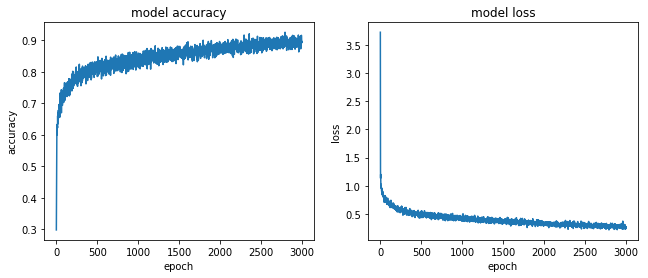

In [18]:
plt.subplot(1,2,1)
plt.plot(acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplots_adjust(right=1.5)
plt.show()

### Without validation data it is difficult to tell whether the model is overfitting. However, the previous experiments suggest that further training might cause overfitting. The above model is saved and its performance analyzed in the next notebook: Evaluate.

In [19]:
model.save("Model/Scratch_Aug_1_hrange_pm20_v3.h5")